# MIE 1624: Final Project

# news_Busters

#### Group 22 Members

Aaron Hao Tan, Gurtej Bhasin, Elise Emma, Jacob Bulir, Alex Kwan

## Introduction 

< -- Insert brief intro to project -- >

## Table of Content 

#### 0. Preliminaries

#### 1. Data Cleaning
    - 1.1 Claim Cleaning
    - 1.2 Related Articles Cleaning
        - 1.2.1 Extract Sentences
    - 1.3 Removing Stopwords and Stemming
        - 1.3.1 Claims
        - 1.3.2 Related Articles
    - 1.4 Date Cleaning
    - 1.5 Claimant Cleaning
    - 1.6 Finalize Cleaned Data
        - 1.6.1 Finalize Train Data
        - 1.6.2 Finalize Related Articles Data

#### 2. Exploratory Data Analysis
    - 2.1 Basic Exploration
    - 2.2 Date Features
        - 2.2.1 Additional Date Features and Analysis
    - 2.3 Claimant Features
    - 2.4 Doc2Vec Features
        - 2.4.1 Preprocess the Data
        - 2.4.2 Prepare for Training
        - 2.4.3 Doc2Vec Training
        - 2.4.4 Find Similarities
            - 2.4.4.1 Finding Top 5 Sentences per Related Articles per Claim
            - 2.4.4.2 Finding Top 5 Sentences Amongst all Related Articles per Claim
        - 2.4.5 Feature Encoding
            - 2.4.5.1 Feature Encode the Claims
            - 2.4.5.2 Feature Encode the Top 5 Related Article Sentences for Each Claim
            - 2.4.5.3 Feature Encode the Similarity Scores
        - 2.4.6 Combine All Features (Claim Vector, Top 5 Related Sentence Vector, Similarity Scores)
    - 2.5 Sentiment Features
    - 2.6 Parts of Speech Features
        - 2.6.1 Top Words and Frequency of the Words from All Related Articles per Claim
        - 2.6.2 Weighted Sum of Overlapping Words between Claim and Related Articles
        - 2.6.3 Number of Words per Claim
        - 2.6.4 Number of Stopwords per Claim
        - 2.6.5 Number of Special Characters per Claim
        - 2.6.6 Number of Characters per Claim
    - 2.7 Linguistic Features using Spacy
        - 2.7.1 Claimant Groups
        - 2.7.2 Noun Phrases, Verbs, Nouns, Adjectives and Punctuations on Claims
    - 2.8 Combining all Features

#### 3. Feature Encoding and Selection
    - 3.1 Feature Preparation
    - 3.2 Feature Encoding
    - 3.3 ExtraTreeClassifier for Feature Selection
    - 3.4 Correlation

#### 4. Model Implementation and Tuning
    - 4.1 Logistic Regression with Grid Search for Hyperparameter Tuning
    - 4.2 k-Nearest Neighbors
    - 4.3 Decision Trees
    - 4.4 Support Vector Machine
    - 4.5 Ensemble Model

#### 5. Results
    - 5.1 Model Scores
    - 5.2 Distribution of True vs. Predicted Labels
    - 5.3 Confusion Matrix

## Preliminaries

In [1]:
#----------------------------------------------
# Import Libraries
#----------------------------------------------
# !pip install vaderSentiment
# !pip install -U spacy

import pandas as pd
import numpy as np
import numpy
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import re
from datetime import datetime
import os
import math
from IPython.display import clear_output, display
import time
import warnings
warnings.filterwarnings('ignore')
import string
import heapq
from heapq import nlargest
from operator import itemgetter
import random

# sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from nltk.stem.snowball import SnowballStemmer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


# The following line is needed to show plots inline in notebooks
%matplotlib inline 

Requirement already up-to-date: spacy in /home/aaron/.local/lib/python3.5/site-packages (2.2.3)


## 1. Data Cleaning 

In this section, the train.json file as well as the related articles are cleaned. The output of this section are two data frames that hold the cleaned information. The following shows the subsections:

- 1.1 Claim Cleaning
- 1.2 Related Articles Cleaning
    - 1.2.1 Extract Sentences
- 1.3 Removing Stopwords and Stemming
    - 1.3.1 Claims
    - 1.3.2 Related Articles
- 1.4 Date Cleaning
- 1.5 Claimant Cleaning
- 1.6 Finalize Cleaned Data
    - 1.6.1 Finalize Train Data
    - 1.6.2 Finalzie Related Articles Data

### 1.1 Claim Cleaning

Read the "train.json" file and perform some basic cleaning on the claims. This includes the following key points:

    - Lowercase all claims
    - Remove "\n" new lines
    - Remove URL links
    - Remove unicode hex
    - Remove punctuations
    - Remove misc. items such as "-", "'" ... etc.
    - Remove any extra spaces

In [2]:
# read train.json file for training data
data = pd.read_json("train.json")
data.shape

(15555, 6)

In [3]:
%%time

# CLEAN CLAIM DATA

# create a new dataframe of just claims
cleaned_claim = data.claim.to_frame()

# convert all string values to lower case
cleaned_claim = cleaned_claim.apply(lambda x: x.str.lower())

# replace new line with space
cleaned_claim = cleaned_claim.replace('\n', ' ', regex=True)

# get rid of all links
cleaned_claim = cleaned_claim.claim.replace(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}     /)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', regex = True).to_frame()

# get rid of unicode hex
cleaned_claim = cleaned_claim.claim.replace({r'[^\x00-\x7F]+':''}, regex=True).to_frame()

# remove punctuation
cleaned_claim = cleaned_claim.claim.str.replace('[{}]'.format(string.punctuation), '').to_frame()

# remove misc items
cleaned_claim = cleaned_claim.replace(' — ', ' ', regex=True)
cleaned_claim = cleaned_claim.replace('-', ' ', regex=True)
cleaned_claim = cleaned_claim.replace('’', '', regex=True)
cleaned_claim = cleaned_claim.replace('‘', '', regex=True)
cleaned_claim = cleaned_claim.replace('”', '', regex=True)
cleaned_claim = cleaned_claim.replace('“', '', regex=True)

# replace consecutive spaces with just one space
cleaned_claim = cleaned_claim.replace('\s+', ' ', regex=True)

CPU times: user 445 ms, sys: 2.7 ms, total: 448 ms
Wall time: 447 ms


For ease of manipulation, the related articles information are converted in to numpy arrays with the following code segment.

In [4]:
# convert related_articles list to a row of array

article_array = []
for i in range(data.shape[0]):
    array = np.asarray(data['related_articles'].loc[i])
    article_array.append(array)
    
data['article_array'] = article_array

The cleaned claims, labels and the related articles in array format are shown below.

In [5]:
# concatenate cleaned_claims with label and article_array
cleaned_claim = pd.concat([cleaned_claim, data.label, data.article_array], axis=1)

# cleaned_claim now holds the claims that are cleaned, the label, and the article array
cleaned_claim.head()

,claim,label,article_array
0,a line from george orwells novel 1984 predicts...,0,"[122094, 122580, 130685, 134765]"
1,maine legislature candidate leslie gibson insu...,2,"[106868, 127320, 128060]"
2,a 17yearold girl named alyssa carson is being ...,1,"[132130, 132132, 149722]"
3,in 1988 author roald dahl penned an open lette...,2,"[123254, 123418, 127464]"
4,when it comes to fighting terrorism another th...,2,"[41099, 89899, 72543, 82644, 95344, 88361]"


### 1.2 Related Articles Cleaning

Similar to the procedures used to clean the claims, we clean the related articles in this section. To begin, we first create a dataframe that holds every related article. The index in this case are the article ID's.

In [6]:
%%time

# set paths
cur_path = os.path.dirname(os.path.abspath("Final_Project.ipynb"))
articles_dir = cur_path + '/train_articles/'

# create a dictionary of article ID and content
article_dict = {}
for filename in os.listdir(articles_dir):
    filenumber = filename.replace('.txt', '')
    file_open = open(articles_dir + filename, "r")
    text = file_open.read()
    article_dict[filenumber] = text
    
# use the dictionary created to create a dataframe of articles
articles  = pd.DataFrame.from_dict(article_dict, orient='index')
articles.columns = ['Article']

# a dataframe that holds all the articles
articles.head()

CPU times: user 1.44 s, sys: 459 ms, total: 1.9 s
Wall time: 1.91 s


,Article
125923,FACT CHECK: The Five Pillars of Curriculum\nFA...
57270,"The State Department Spent $52,701 on the Curt..."
144732,US show of force sends Russia a message in Bla...
28766,Mexico missing students: Protesters clash with...
85305,The U.S. Refugee Resettlement Program: A Prime...


With the related articles dataframe, the following performs the basic cleaning that was also applied to the claims.

In [7]:
%%time

# CLEAN ARTICLE DATA - ~5 minutes to run

# convert all string values to lower case
articles_cleaned = articles.apply(lambda x: x.str.lower())

# replace new line with space
articles_cleaned = articles_cleaned.replace('\n', ' ', regex=True)

# get rid of all links
articles_cleaned = articles_cleaned.Article.replace(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}     /)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', regex = True).to_frame()

# get rid of unicode hex
articles_cleaned = articles_cleaned.Article.replace({r'[^\x00-\x7F]+':''}, regex=True).to_frame()

# remove misc items
articles_cleaned = articles_cleaned.replace(' — ', ' ', regex=True)
articles_cleaned = articles_cleaned.replace('-', '', regex=True)
articles_cleaned = articles_cleaned.replace('’', '', regex=True)
articles_cleaned = articles_cleaned.replace('‘', '', regex=True)
articles_cleaned = articles_cleaned.replace('”', '', regex=True)
articles_cleaned = articles_cleaned.replace('“', '', regex=True)

# replace consecutive spaces with just one space
articles_cleaned = articles_cleaned.replace('\s+', ' ', regex=True)

CPU times: user 1min 54s, sys: 653 ms, total: 1min 55s
Wall time: 1min 55s


### 1.2.1 Extract Sentences from Related Articles

In this section, we perform sentence tokenization on all the related articles to extract individual sentences from each article. Puntuations are then removed from the extracted sentences.

In [8]:
%%time

# split each article in to sentences by "sent_tokenize"
from nltk import sent_tokenize
article_sentences = []
for i in range(articles_cleaned.shape[0]):
    sentence = articles_cleaned.Article[articles_cleaned.index[i]]
    tok_sen = sent_tokenize(sentence)
    article_sentences.append(tok_sen)

CPU times: user 2min 2s, sys: 552 ms, total: 2min 2s
Wall time: 2min 3s


In [9]:
# remove punctuation from cleaned articles - had to do this after the sentences are separated
articles_cleaned = articles_cleaned.Article.str.replace('[{}]'.format(string.punctuation), '').to_frame()

In [10]:
%%time

# remove punctuation from sentences
cleaned_article_sent = []
for i in range(articles_cleaned.shape[0]):
    cleaned_sent = [''.join(c for c in s if c not in string.punctuation) for s in article_sentences[i]]
    # cleaned_article_sent is a list of lists
    # the sentences from each article is grouped in to a list, and then grouped together based on article
    cleaned_article_sent.append(cleaned_sent)

CPU times: user 50.4 s, sys: 388 ms, total: 50.8 s
Wall time: 50.8 s


The following shows the article sentences dataframe, where each cell holds a list of sentences, indexed by the related article ID.

In [11]:
# convert the cleaned_Article_sent in to a dataframe that's indexed by article ID
article_sentences = pd.Series(cleaned_article_sent).to_frame()
article_sentences.columns = ['Sentence']
article_sentences.index = articles_cleaned.index

# article sentences in a dataframe
article_sentences.head()

,Sentence
125923,[fact check the five pillars of curriculum fac...
57270,[the state department spent 52701 on the curta...
144732,[us show of force sends russia a message in bl...
28766,[mexico missing students protesters clash with...
85305,[the us refugee resettlement program a primer ...


### 1.3 Remove Stopwords and Stemming

Now that the basic cleaning and sentence extraction are completed, the next step is to remove stopwords and perform stemming on the remaining words. The purpose is to reduce the vocabulary space by keeping only the words that are meaningful.The following imports the necessary libraries to conduct these tasks.

In [12]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
# the first time running - you may need to uncomment the bottom two lines to download the necessary packages
# nltk.download('stopwords')
# nltk.download('punkt')

### 1.3.1 Claims

This section removes the stopwords and stems the claims.

In [13]:
# create a list of claims
claim_list=[]
for i in range(cleaned_claim.shape[0]):
    claim_entry = cleaned_claim.claim.loc[i]
    claim_list.append(claim_entry)

In [14]:
%%time
# tokenize every claim in the claim list generated from above
# the result is a list of tokenized claims: tokenized_claims
tokenized_claims = []
stemmed_claims = []
stemmed_sw_claims = []
for i in range(cleaned_claim.shape[0]):

    #--------------------------------------------------------------
    # stemming
    word_tokens = word_tokenize(claim_list[i])
    stemmed_tok_claims = []
    for w in word_tokens:
        stemmed_tok_claims.append(ps.stem(w))
    stemmed_string = ' '.join(stemmed_tok_claims)
    # stemmed_claims is a list of stemmed strings
    stemmed_claims.append(stemmed_string)
    
    #--------------------------------------------------------------
    # remove stop words
    stemmed_sw_string = []
    word_tokens = word_tokenize(stemmed_claims[i])
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    stemmed_sw_string = ' '.join(filtered_sentence)
    # stemmed_sw_claims is a list of stemmed strings without stopwords
    stemmed_sw_claims.append(stemmed_sw_string)    
        
    #--------------------------------------------------------------    
    # tokenize
    tokenized_ = word_tokenize(stemmed_sw_claims[i])
    tokenized_claims.append(tokenized_)
    
    # print progress
    progress = round((i/cleaned_claim.shape[0])*100,2)
    clear_output(wait=True)
    print("progress: " + str(progress) + "%")

progress: 99.99%
CPU times: user 34.6 s, sys: 2.33 s, total: 36.9 s
Wall time: 34 s


### Create Claims Dataframe

The stemmed claims without stopwords are added to a claims dataframe here. In order to keep as much information as possible, each column below represent the claim at each level of the cleaning.

In [15]:
# zip together all the claim lists and create a dataframe
zipped_claims = list(zip(stemmed_claims, stemmed_sw_claims, tokenized_claims))
claims_ = pd.DataFrame(zipped_claims, columns = ['stemmed_claims', 'stemmed_stopword_claims', 'tokenized_claims'])

#display the claims dataframe
claims_.head()

,stemmed_claims,stemmed_stopword_claims,tokenized_claims
0,a line from georg orwel novel 1984 predict the...,line georg orwel novel 1984 predict power smar...,"[line, georg, orwel, novel, 1984, predict, pow..."
1,main legislatur candid lesli gibson insult par...,main legislatur candid lesli gibson insult par...,"[main, legislatur, candid, lesli, gibson, insu..."
2,a 17yearold girl name alyssa carson is be trai...,17yearold girl name alyssa carson train nasa b...,"[17yearold, girl, name, alyssa, carson, train,..."
3,in 1988 author roald dahl pen an open letter u...,1988 author roald dahl pen open letter urg par...,"[1988, author, roald, dahl, pen, open, letter,..."
4,when it come to fight terror anoth thing we kn...,come fight terror anoth thing know doe work ba...,"[come, fight, terror, anoth, thing, know, doe,..."


### 1.3.2 Related Articles

Similar to the procedure performed on the claims, this section removes stopwords and stems the sentences extracted from the related articles.

In [16]:
%%time
# create a list of tokenized, non-stop words articles ~ takes 30 min
tokenized_articles = []
stemmed_art = []
stemmed_sw_art = []

for i in range(articles_cleaned.shape[0]):

    #--------------------------------------------------------------
    # stemming
    word_tokens = word_tokenize(articles_cleaned.Article[articles_cleaned.index[i]])
    stemmed_tok_art = []
    for w in word_tokens:
        stemmed_tok_art.append(ps.stem(w))
    stemmed_string = ' '.join(stemmed_tok_art)
    # stemmed_claims is a list of stemmed strings
    stemmed_art.append(stemmed_string)
    
    #--------------------------------------------------------------
    # remove stop words
    stemmed_sw_string = []
    word_tokens = word_tokenize(stemmed_art[i])
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    stemmed_sw_string = ' '.join(filtered_sentence)
    # stemmed_sw_claims is a list of stemmed strings without stopwords
    stemmed_sw_art.append(stemmed_sw_string)    
    
    #--------------------------------------------------------------    
    # tokenize
    tokenized_ = word_tokenize(stemmed_sw_art[i])
    tokenized_articles.append(tokenized_)
    
    # print progress
    progress = round((i/articles_cleaned.shape[0])*100,2)
    clear_output(wait=True)
    print("progress: " + str(progress) + "%")

progress: 100.0%
CPU times: user 31min 20s, sys: 21 s, total: 31min 41s
Wall time: 31min 24s


#### Sentences for Related Articles

In [17]:
%%time

# stem, remove stop words from sentences ~ takes 30 min

one_article = []
final_article_sentences = []
tokenized_sentences = []
final_article_tok_sentences = []

for i in range(article_sentences.shape[0]):
    # grab a series of sentence for one article
    sentence_list = article_sentences.Sentence[article_sentences.index[i]]
    for u in range(len(sentence_list)):
        # stem, stopwords for each sentence in an article
        sent = sentence_list[u]
        word_tokens = word_tokenize(sent)
        stemmed_tok_sent = []
        for w in word_tokens:
            stemmed_tok_sent.append(ps.stem(w))
        filtered_sentence = [w for w in stemmed_tok_sent if not w in stop_words]
        # append the tokenized strings
        tokenized_sentences.append(filtered_sentence)
        # append the strings
        stemmed_sw_string = ' '.join(filtered_sentence)
        one_article.append(stemmed_sw_string)
    # append each one_article to a full list of all articles
    final_article_sentences.append(one_article)  
    final_article_tok_sentences.append(tokenized_sentences)
    one_article = []
    tokenized_sentences = []
    
    # print progress
    progress = round((i/article_sentences.shape[0])*100,2)
    clear_output(wait=True)
    print("progress: " + str(progress) + "%")    

progress: 100.0%
CPU times: user 29min 27s, sys: 26.5 s, total: 29min 54s
Wall time: 29min 38s


The sentences from the related articles at each level of the cleaning are shown below.

In [18]:
# article_sentences is the dataframe that holds the sentences
article_sentences['cleaned_sentence'] = final_article_sentences
article_sentences['tokenized_cleaned_sentence'] = final_article_tok_sentences
article_sentences.head()

,Sentence,cleaned_sentence,tokenized_cleaned_sentence
125923,[fact check the five pillars of curriculum fac...,[fact check five pillar curriculum fact check ...,"[[fact, check, five, pillar, curriculum, fact,..."
57270,[the state department spent 52701 on the curta...,[state depart spent 52701 curtain un ambassado...,"[[state, depart, spent, 52701, curtain, un, am..."
144732,[us show of force sends russia a message in bl...,[us show forc send russia messag black sea was...,"[[us, show, forc, send, russia, messag, black,..."
28766,[mexico missing students protesters clash with...,[mexico miss student protest clash polic media...,"[[mexico, miss, student, protest, clash, polic..."
85305,[the us refugee resettlement program a primer ...,[us refuge resettl program primer policymak pr...,"[[us, refuge, resettl, program, primer, policy..."


### Create Related Articles DataFrame

The cleaned related articles as well as the sentences are combined together into a single dataframe with the code presented below.

In [19]:
# zip together all the articles and create a dataframe
zipped_articles = list(zip(stemmed_art, stemmed_sw_art, tokenized_articles, final_article_sentences, final_article_tok_sentences))
articles_ = pd.DataFrame(zipped_articles, columns = ['stemmed_articles', 'stemmed_stopword_articles', 'tokenized_articles', 'cleaned_sentence', 'tokenized_cleaned_sentence'])

# index the articles based on article ID
articles_.index = [articles_cleaned.index]

# display the articles_
articles_.head()

,stemmed_articles,stemmed_stopword_articles,tokenized_articles,cleaned_sentence,tokenized_cleaned_sentence
125923,fact check the five pillar of curriculum fact ...,fact check five pillar curriculum fact check s...,"[fact, check, five, pillar, curriculum, fact, ...",[fact check five pillar curriculum fact check ...,"[[fact, check, five, pillar, curriculum, fact,..."
57270,the state depart spent 52701 on the curtain in...,state depart spent 52701 curtain un ambassador...,"[state, depart, spent, 52701, curtain, un, amb...",[state depart spent 52701 curtain un ambassado...,"[[state, depart, spent, 52701, curtain, un, am..."
144732,us show of forc send russia a messag in black ...,us show forc send russia messag black sea wash...,"[us, show, forc, send, russia, messag, black, ...",[us show forc send russia messag black sea was...,"[[us, show, forc, send, russia, messag, black,..."
28766,mexico miss student protest clash with polic m...,mexico miss student protest clash polic media ...,"[mexico, miss, student, protest, clash, polic,...",[mexico miss student protest clash polic media...,"[[mexico, miss, student, protest, clash, polic..."
85305,the us refuge resettl program a primer for pol...,us refuge resettl program primer policymak pre...,"[us, refuge, resettl, program, primer, policym...",[us refuge resettl program primer policymak pr...,"[[us, refuge, resettl, program, primer, policy..."


### 1.4. Date Cleaning

For ease of data manipulation, the date is converted to "datetime" format and added as a new column "new_date".

In [20]:
# Convert date column to datetime format
data['new_date'] = pd.to_datetime(data['date'], dayfirst=True)
data.head()

,claim,claimant,date,id,label,related_articles,article_array,new_date
0,A line from George Orwell's novel 1984 predict...,,2017-07-17,0,0,"[122094, 122580, 130685, 134765]","[122094, 122580, 130685, 134765]",2017-07-17
1,Maine legislature candidate Leslie Gibson insu...,,2018-03-17,1,2,"[106868, 127320, 128060]","[106868, 127320, 128060]",2018-03-17
2,A 17-year-old girl named Alyssa Carson is bein...,,2018-07-18,4,1,"[132130, 132132, 149722]","[132130, 132132, 149722]",2018-07-18
3,In 1988 author Roald Dahl penned an open lette...,,2019-02-04,5,2,"[123254, 123418, 127464]","[123254, 123418, 127464]",2019-02-04
4,"When it comes to fighting terrorism, ""Another ...",Hillary Clinton,2016-03-22,6,2,"[41099, 89899, 72543, 82644, 95344, 88361]","[41099, 89899, 72543, 82644, 95344, 88361]",2016-03-22


### 1.5. Claimant Cleaning 

All empty claimant cells are replaced with "Unknown" in this section.

In [36]:
# fill missing claimants with "unknown"
data['claimant'] = data['claimant'].fillna('Unknown')
data['claimant'] = data['claimant'].replace('', 'Unknown')
data.head()

,claim,claimant,date,id,label,related_articles,article_array,new_date
0,A line from George Orwell's novel 1984 predict...,Unknown,2017-07-17,0,0,"[122094, 122580, 130685, 134765]","[122094, 122580, 130685, 134765]",2017-07-17
1,Maine legislature candidate Leslie Gibson insu...,Unknown,2018-03-17,1,2,"[106868, 127320, 128060]","[106868, 127320, 128060]",2018-03-17
2,A 17-year-old girl named Alyssa Carson is bein...,Unknown,2018-07-18,4,1,"[132130, 132132, 149722]","[132130, 132132, 149722]",2018-07-18
3,In 1988 author Roald Dahl penned an open lette...,Unknown,2019-02-04,5,2,"[123254, 123418, 127464]","[123254, 123418, 127464]",2019-02-04
4,"When it comes to fighting terrorism, ""Another ...",Hillary Clinton,2016-03-22,6,2,"[41099, 89899, 72543, 82644, 95344, 88361]","[41099, 89899, 72543, 82644, 95344, 88361]",2016-03-22


### 1.6. Finalize Train and Related Articles Data

With the train.json and related articles cleaned, this section forms two complete dataframes that hold the necessary information.

### 1.6.1 Finalize Cleaned Train Data

This section finalizes the cleaned train data which include the raw claim, cleaned claim, stemmed claims, stemmed claims without stopwords, tokenized claims, claimants, label, related article array and the dates.

In [45]:
# concatenate all work done above to a single frame
final_data = pd.concat([data.claim, cleaned_claim.claim, claims_.stemmed_claims, claims_.stemmed_stopword_claims, claims_.tokenized_claims, data.claimant, cleaned_claim.label, cleaned_claim.article_array, data.new_date], axis=1)

# rename columns for clarity
final_data.columns = ['raw_claim', 'cleaned_claim', 'stemmed_claims', 'stemmed_stopword_claims', 'tokenized_claim', 'claimant', 'label', 'article_array', 'new_date']

In [46]:
# this is equivalent to the "train.csv" that we were given, but cleaned
final_data.head()

,raw_claim,cleaned_claim,stemmed_claims,stemmed_stopword_claims,tokenized_claim,claimant,label,article_array,new_date
0,A line from George Orwell's novel 1984 predict...,a line from george orwells novel 1984 predicts...,a line from georg orwel novel 1984 predict the...,line georg orwel novel 1984 predict power smar...,"[line, georg, orwel, novel, 1984, predict, pow...",Unknown,0,"[122094, 122580, 130685, 134765]",2017-07-17
1,Maine legislature candidate Leslie Gibson insu...,maine legislature candidate leslie gibson insu...,main legislatur candid lesli gibson insult par...,main legislatur candid lesli gibson insult par...,"[main, legislatur, candid, lesli, gibson, insu...",Unknown,2,"[106868, 127320, 128060]",2018-03-17
2,A 17-year-old girl named Alyssa Carson is bein...,a 17yearold girl named alyssa carson is being ...,a 17yearold girl name alyssa carson is be trai...,17yearold girl name alyssa carson train nasa b...,"[17yearold, girl, name, alyssa, carson, train,...",Unknown,1,"[132130, 132132, 149722]",2018-07-18
3,In 1988 author Roald Dahl penned an open lette...,in 1988 author roald dahl penned an open lette...,in 1988 author roald dahl pen an open letter u...,1988 author roald dahl pen open letter urg par...,"[1988, author, roald, dahl, pen, open, letter,...",Unknown,2,"[123254, 123418, 127464]",2019-02-04
4,"When it comes to fighting terrorism, ""Another ...",when it comes to fighting terrorism another th...,when it come to fight terror anoth thing we kn...,come fight terror anoth thing know doe work ba...,"[come, fight, terror, anoth, thing, know, doe,...",Hillary Clinton,2,"[41099, 89899, 72543, 82644, 95344, 88361]",2016-03-22


In [47]:
# save to pkl
final_data.to_pickle("./final_data.pkl")

### 1.6.2 Finalize Cleaned Related Articles Data

This part combines the necessary related article information in to a single dataframe. The columns contains the raw articles, cleaned articles, stemmed articles, stemmed articles without stopwords, tokenized articles, the cleaned sentences and lastly the tokenized cleaned sentences.

In [39]:
raw_article_list = articles.Article.tolist()
cleaned_article_list = articles_cleaned.Article.tolist()
final_articles_zipped = list(zip(raw_article_list, cleaned_article_list, stemmed_art, stemmed_sw_art, tokenized_articles, final_article_sentences, final_article_tok_sentences))
final_articles = pd.DataFrame(final_articles_zipped, columns = ['raw_articles', 'cleaned_articles', 'stemmed_articles', 'stemmed_stopwords_articles', 'tokenized_articles', 'cleaned_sentence', 'tokenized_cleaned_sentence'])
final_articles.index = [articles_cleaned.index]

In [40]:
final_articles.head()

,raw_articles,cleaned_articles,stemmed_articles,stemmed_stopwords_articles,tokenized_articles,cleaned_sentence,tokenized_cleaned_sentence
125923,FACT CHECK: The Five Pillars of Curriculum\nFA...,fact check the five pillars of curriculum fact...,fact check the five pillar of curriculum fact ...,fact check five pillar curriculum fact check s...,"[fact, check, five, pillar, curriculum, fact, ...",[fact check five pillar curriculum fact check ...,"[[fact, check, five, pillar, curriculum, fact,..."
57270,"The State Department Spent $52,701 on the Curt...",the state department spent 52701 on the curtai...,the state depart spent 52701 on the curtain in...,state depart spent 52701 curtain un ambassador...,"[state, depart, spent, 52701, curtain, un, amb...",[state depart spent 52701 curtain un ambassado...,"[[state, depart, spent, 52701, curtain, un, am..."
144732,US show of force sends Russia a message in Bla...,us show of force sends russia a message in bla...,us show of forc send russia a messag in black ...,us show forc send russia messag black sea wash...,"[us, show, forc, send, russia, messag, black, ...",[us show forc send russia messag black sea was...,"[[us, show, forc, send, russia, messag, black,..."
28766,Mexico missing students: Protesters clash with...,mexico missing students protesters clash with ...,mexico miss student protest clash with polic m...,mexico miss student protest clash polic media ...,"[mexico, miss, student, protest, clash, polic,...",[mexico miss student protest clash polic media...,"[[mexico, miss, student, protest, clash, polic..."
85305,The U.S. Refugee Resettlement Program: A Prime...,the us refugee resettlement program a primer f...,the us refuge resettl program a primer for pol...,us refuge resettl program primer policymak pre...,"[us, refuge, resettl, program, primer, policym...",[us refuge resettl program primer policymak pr...,"[[us, refuge, resettl, program, primer, policy..."


In [42]:
final_articles.to_pickle('./final_articles.pkl')

## 2. Exploratory Data Analysis

In the EDA section, we look to find trends in the data and offer insightful observations and visuals. We focus on the generating new features from information that is present in the data. Examples of this include analysis of the words used in the claim and the related articles, the date the claim was made, the person who made the claim, as well as overall sentiment analysis. EDA is crucial for allowing us to understand the patterns and trends in the data so that we can then interpret our results and check that they are reasonable and not over/underfitting the data. The following are the subsections involved in this section which cover the exploration of the data we were given as well as the engineering of new features.

    - 2.1 Basic Exploration
    - 2.2 Date Features
        - 2.2.1 Additional Date Features and Analysis
    - 2.3 Claimant Features
    - 2.4 Doc2Vec Features
        - 2.4.1 Preprocess the Data
        - 2.4.2 Prepare for Training
        - 2.4.3 Doc2Vec Training
        - 2.4.4 Find Similarities
            - 2.4.4.1 Finding Top 5 Sentences per Related Articles per Claim
            - 2.4.4.2 Finding Top 5 Sentences Amongst all Related Articles per Claim
        - 2.4.5 Feature Encoding
            - 2.4.5.1 Feature Encode the Claims
            - 2.4.5.2 Feature Encode the Top 5 Related Article Sentences for Each Claim
            - 2.4.5.3 Feature Encode the Similarity Scores
        - 2.4.6 Combine All Features (Claim Vector, Top 5 Related Sentence Vector, Similarity Scores)
    - 2.5 Sentiment Features
    - 2.6 Parts of Speech Features
        - 2.6.1 Top Words and Frequency of the Words from All Related Articles per Claim
        - 2.6.2 Weighted Sum of Overlapping Words between Claim and Related Articles
        - 2.6.3 Number of Words per Claim
        - 2.6.4 Number of Stopwords per Claim
        - 2.6.5 Number of Special Characters per Claim
        - 2.6.6 Number of Characters per Claim
    - 2.7 Linguistic Features using Spacy
        - 2.7.1 Claimant Groups
        - 2.7.2 Noun Phrases, Verbs, Nouns, Adjectives and Punctuations on Claims
    - 2.8 Combining all Features

In [2]:
data = pd.read_pickle('final_data.pkl')

### 2.1 Basic Exploration

#### Label Count

The distribution of the labels are unbalanced in the dataset that we were given as seen below. The number of "True" labels is relatively small when compared with the other two labels. As a result of this, it is possible that the model trained on this dataset will not be able to correctly predict the "True" labels.

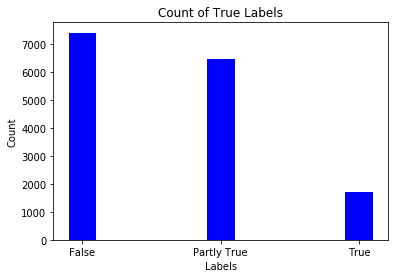

In [8]:
# create a list of true label counts
label_count_list = [(data.label == 0).sum(), (data.label == 1).sum(), (data.label == 2).sum()]

# plot count of true labels
Labels = ['False', 'Partly True', 'True']
x = [1,2,3]
plt.xticks(x, Labels)
plt.ylabel('Count')
plt.xlabel('Labels')
ax = plt.subplot()
ax.bar(x, label_count_list, width=0.2, color='b', align='center')
plt.title('Count of True Labels')
plt.show()

#### Claimant Distribution

Based on the following, it seems that about 30% of the claimant data are unknown. After that, the next few significant claimants are "Donald Trump", "Bloggers", "Barack Obama" and "Hilary Clinton". After Hilary Clinton, the amount of claims made by each claimant make up for roughly 1 to 2 percent each.

Text(0.5, 0, 'Claimants')

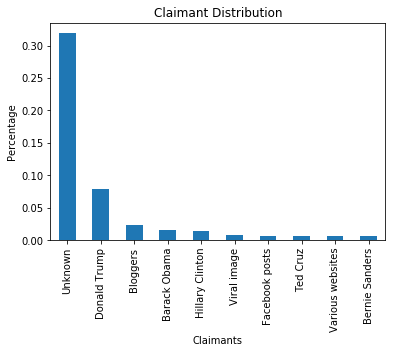

In [21]:
# plot top 10 significant claimants
test = data.claimant.value_counts(normalize=True)
test[0:10].plot(kind='bar')
plt.title('Claimant Distribution')
plt.ylabel('Percentage')
plt.xlabel('Claimants')

#### Date Distribution

It seems that two specific dates; namely, November 6th 2017 and October 23 2016 have a significant larger presence than claims made in other dates. After some research, below are some of the information found about these two dates. It may be interesting to see how these news may affect the truthfulness of claims made.

##### November 6th 2017
- Gunman kills at least 26 at Texas Church
- Trump blames church massacre on mental health problems

##### October 23rd 2016
- Chicago celebrates Cub's first National League Championship since 1945
- New Trump accuser comes forward as Trump threatens to sue
- Tom Hanks joins SNL to spoof the final presidential debate

Text(0.5, 0, 'Claimants')

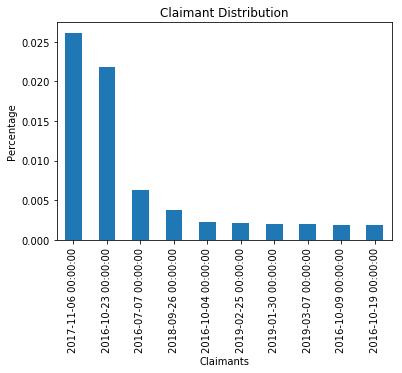

In [23]:
# plot top 10 significant dates
test = data.new_date.value_counts(normalize=True)
test[0:10].plot(kind='bar')
plt.title('Date Distribution')
plt.ylabel('Percentage')
plt.xlabel('Dates')

#### Word Cloud
The wordclouds below visualize the most commonly used words for each type of claim label (true, partly true, false). Based on the wordclouds, we can see that there is overlap between common words such as "Say". However, we also see that true claims use the word "year" much more than partly true and false claims. This makes sense, as a person that can reference the year of a true claim likely has done their research. We will use these findings to guide our future analysis. 

In [4]:
# !pip install wordcloud
import wordcloud as wc

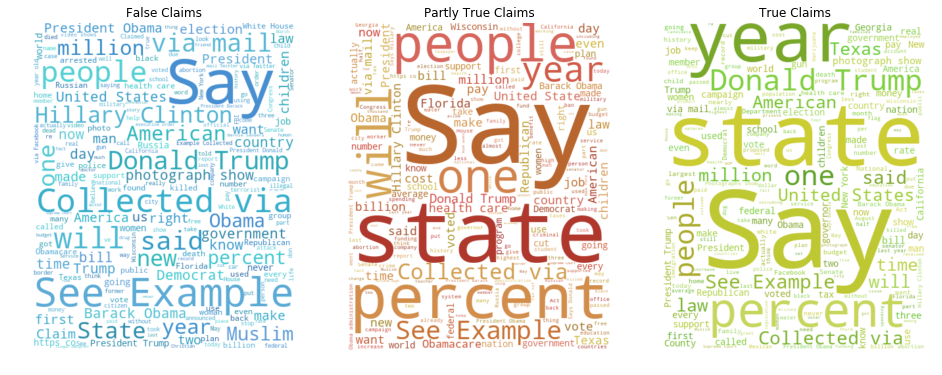

In [5]:
#Merges the words of all claims dependent on the truth label of the claim

false_text = " ".join(data[data.label==0].raw_claim)
partly_text = " ".join(data[data.label==1].raw_claim)
true_text = " ".join(data[data.label==2].raw_claim)
cv='hsl({:d}, 60%, {:d}%)'

#Defines color and sizing of visuals
def bcolor(word, font_size, position, orientation, random_state=None, **kwargs):
    return cv.format(random.randint(180, 210), random.randint(40, 60))

def rcolor(word, font_size, position, orientation, random_state=None, **kwargs):
    return cv.format(random.randint(0, 50), random.randint(40, 60))

def wcolor(word, font_size, position, orientation, random_state=None, **kwargs):
    return cv.format(random.randint(60, 100), random.randint(40, 60))
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=[16,8])

#Plots each wordcloud visual
wordcloud1 = wc.WordCloud(background_color='white', height=500).generate(false_text)
ax1.imshow(wordcloud1.recolor(color_func=bcolor, random_state=3),interpolation="bilinear")
ax1.axis('off');
ax1.set_title('False Claims');

wordcloud2 = wc.WordCloud(background_color='white', height=500).generate(partly_text)
ax2.imshow(wordcloud2.recolor(color_func=rcolor, random_state=3),interpolation="bilinear")
ax2.axis('off');
ax2.set_title('Partly True Claims');

wordcloud3 = wc.WordCloud(background_color='white', height=500).generate(true_text)
ax3.imshow(wordcloud3.recolor(color_func=wcolor, random_state=3),interpolation="bilinear")
ax3.axis('off');
ax3.set_title('True Claims');

### 2.2 Date Features 

This section is focused on creating features from the date information provided.

In [6]:
data = pd.read_pickle('./final_data.pkl')

In [7]:
# create new feature with consecutive days since January 1st, 1986
data['start_date'] = pd.to_datetime('1986-01-01', format='%Y-%m-%d')
data['cont_days'] = (data['new_date'] - data['start_date']).dt.days
data = data.drop(['start_date'], axis=1)

# Convert Year and Month features in to int (instead of str before), can be kept as int since it is ordinal

#Year
data['Year'] = data['new_date'].apply(lambda x: "%d" % (x.year))
data['Year'] = data['Year'].astype(int)

# Month
data['Month'] = data['new_date'].apply(lambda x: "%d" % (x.month))
data['Month'] = data['Month'].astype(int)

#### Claims per Year

The following plot shows the distribution of claims made per year. It seems that 2016 saw a huge jump in claims made when compared to the years prior. Within the dataset, most of the claims happen from 2016 to 2019.

Text(0, 0.5, 'Count')

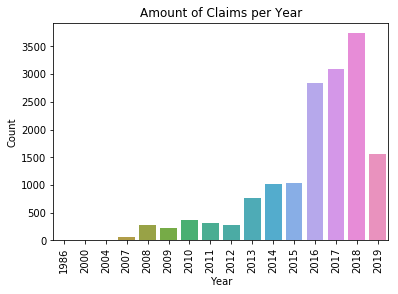

In [8]:
# claims per year
sns.barplot(x=data['new_date'].dt.year.value_counts().index, y=data['new_date'].dt.year.value_counts())
plt.xticks(rotation=90)
plt.title('Amount of Claims per Year')
plt.xlabel('Year')
plt.ylabel('Count')

#### Claims per Month

It seems that there is a roughly even distribution between the claims made per month. The highest amount of claims made per month is October; however, this is likely due to the large amount of claims made on the date of October 23rd 2016 as discussed in previous section.

Text(0, 0.5, 'Count')

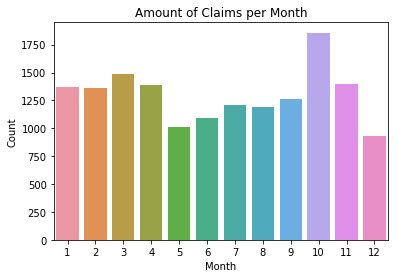

In [9]:
# Claims per month
sns.barplot(x=data['new_date'].dt.month.value_counts().index, y=data['new_date'].dt.month.value_counts())
plt.title('Amount of Claims per Month')
plt.xlabel('Month')
plt.ylabel('Count')

#### Number of Fake/Partly True/True Claims made per Year

It seems that before 2016, "Partly True" news are the most prevalent of all claims made. This trend changed in 2016 when the amount of fake claims made surpassed the "Partly True" news. This trend lines up with the American Election as well as the graphs shown previously. It is likely that the year information may have a correlation with the label.

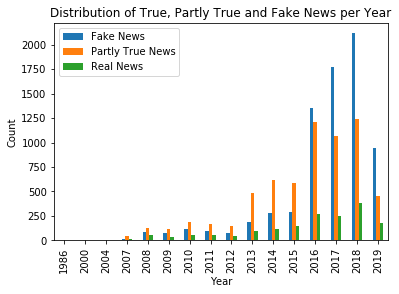

In [10]:
# Plot labels against each year
data['Year'] = data['new_date'].apply(lambda x: "%d" % (x.year))
year_label = data.groupby(['Year', 'label']).size().unstack(fill_value=0)
year_label.plot.bar()
plt.title('Distribution of True, Partly True and Fake News per Year')
plt.ylabel('Count')
plt.legend(["Fake News", "Partly True News", "Real News"])
# 0 = false, 1 = partly true, 2 = true

#### Number of Fake/Partly True/True Claims made per Month

Similar to the graph of claims made per month, it seems that the trend is relatively even throughout all months. The only thing worth noting here is that the amount of Fake and Partly True claims are comparable until October/November/December. In these 3 months, there is a larget difference between Fake and Partly True claims. The amount of True claims remains stable throughout all months.

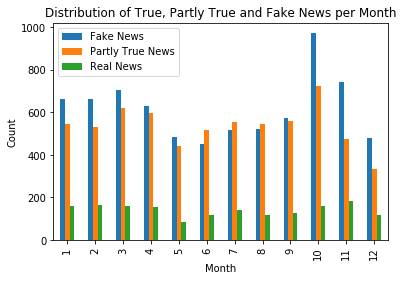

In [11]:
# Plot labels against each month
data['Month'] = data['new_date'].apply(lambda x: "%d" % (x.month))
month_label = data.groupby(['Month', 'label']).size().unstack(fill_value=0)
# For some reason, have to reorder the month index by adding a new column
month_order = [1, 10, 11, 12, 2, 3, 4, 5, 6, 7, 8, 9]
month_label['month'] = month_order
month_label = month_label.sort_values(by=['month'])
# Dropping the added column as it is not needed after reordering
month_label = month_label.drop(['month'], axis=1)
month_label.plot.bar()

plt.title('Distribution of True, Partly True and Fake News per Month')
plt.ylabel('Count')
plt.legend(["Fake News", "Partly True News", "Real News"])

In [12]:
# save data to pickle
data.to_pickle('./final_data_dates.pkl')

### 2.2.1 Additional Date Features and Analysis

#### New Features Generated (Process discussed in the section below):
1. Day of week
2. IsWeekend?
3. Season of year
4. Semester of year

In [13]:
# read pickle
data = pd.read_pickle('./final_data_dates.pkl')

We visualize the amount of claims for a given week (range 1-52) for all the years for which we have data, as shown in the cell below. We see that each year varies drastically in the amount of claims. For example, year 2012 only has an average of 12 claims per week (in this dataset), whereas year 2016 has an average of around 50 and a peak of over 400. 

With this in mind, we developed new features with dates that take into account the seasonal nature of claims on a per year basis. For example, we see that there are a larger amount of claims being made toward the end of the year. We made more features with the idea that we will then eliminate them based on the correlation between them and the label.

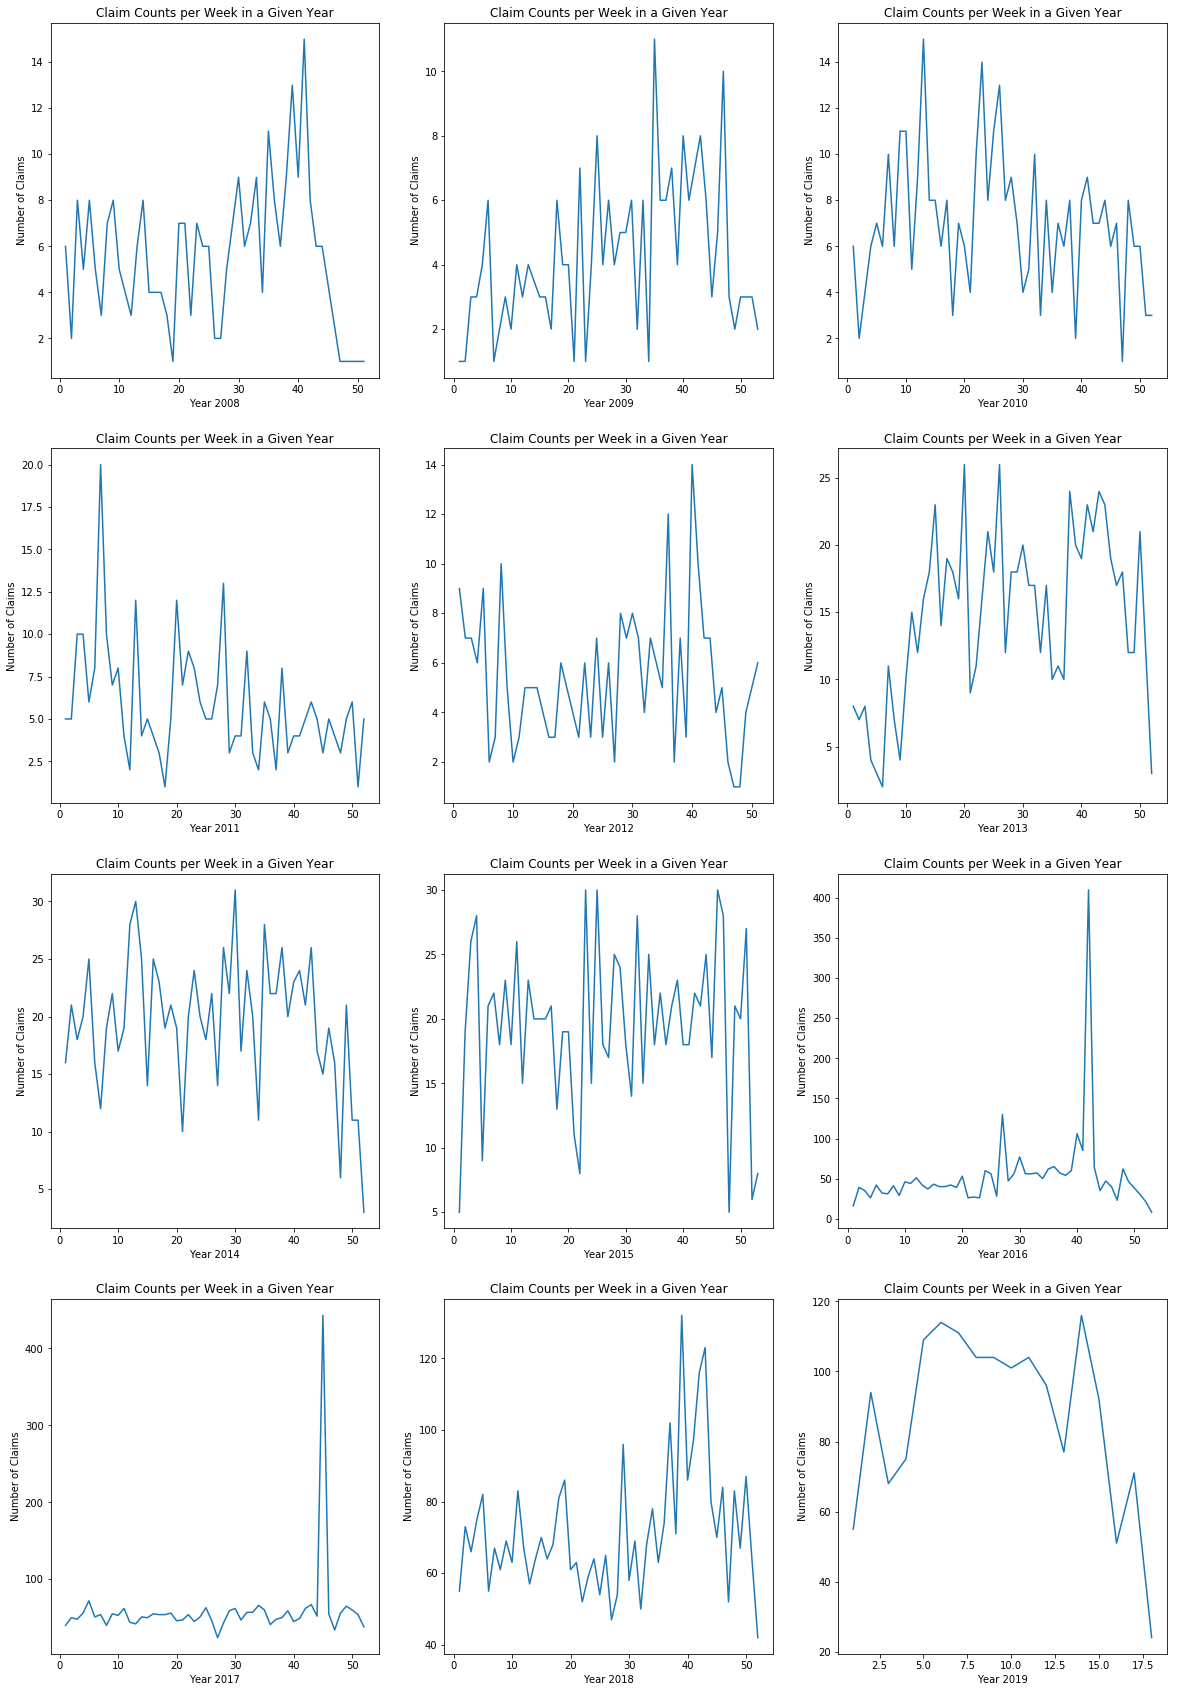

In [14]:
#Plots the amount of claims per week for a given year
fig = plt.figure(figsize=(20,30))
yr_list = list(range(2008, 2020))
for i in range(1, 13):
    plt.subplot(4,3, i)
    data2 = data["new_date"].dt.year.isin([yr_list[i-1]])
    plt.plot(data[data2]["new_date"].dt.week.value_counts().sort_index())
    plt.xlabel("Year " + str(i + 2007))
    plt.ylabel("Number of Claims")
    plt.title("Claim Counts per Week in a Given Year")

#### Day of Week

We defined days since the first claim was made. We then adjusted a mod 7 function to correspond to Monday = 1, Tuesday = 2, ... Sunday = 7. This approach is resilient to leap years and other factors, since monday will always follow sunday and similar for the rest of the days.

In [15]:
#Use days since first claim and mod function to determine the day of week
data2 = pd.DataFrame()
data2["day_of_week"] = data["cont_days"].apply(lambda x: ((x+2) % 7) + 1)
#Map to corresponding strings
day_dic = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
data2.replace({"day_of_week": day_dic}, inplace=True)

#### IsWeekend?

In [16]:
#If Friday-Sunday, then assign Weekend label
data2["is_weekend"] = data2["day_of_week"].apply(lambda x: 'Weekend' if x in ['Friday','Saturday','Sunday'] else 'notWeekend')

#### Transformation of Year into Quarters

The following two features are meant to potentially identify seasonal trends independent of the year the claim was made. For example, this representation could identify if more false claims were made between november-december in each year. This is partially an extension of the month feature.

In [17]:
#Divide year into four different seasons and label accordingly
def season_buckets(month):
    if month <= 3:
        return 'Jan-March'
    elif month <= 6:
        return 'April-June'
    elif month <= 9:
        return 'July-September'
    elif month <= 12:
        return 'October-December'
    else:
        return 0

In [18]:
data2["season"] = data["Month"].astype(int).apply(season_buckets)

#### Transformation of Year into Semesters

In [19]:
#Define which half of the year a date belongs to based off of month value
def semester_buckets(month):
    if month <= 6:
        return 'Jan-June'
    elif month <= 12:
        return 'July-December'
    else:
        return 0
data2["semester"] = data["Month"].astype(int).apply(semester_buckets)
data2.head(5)

,day_of_week,is_weekend,season,semester
0,Monday,notWeekend,July-September,July-December
1,Saturday,Weekend,Jan-March,Jan-June
2,Wednesday,notWeekend,July-September,July-December
3,Monday,notWeekend,Jan-March,Jan-June
4,Tuesday,notWeekend,Jan-March,Jan-June


In [20]:
day_dum = pd.get_dummies(data2['day_of_week'], prefix = 'day')
weekend_dum = pd.get_dummies(data2['is_weekend'])
season_dum = pd.get_dummies(data2['season'], prefix = 'season')
semester_dum = pd.get_dummies(data2['semester'], prefix = 'semester')
year_dum = pd.get_dummies(data['Year'], prefix = 'year')
month_dum = pd.get_dummies(data['Month'], prefix = 'month')

data3 = pd.concat([data['cont_days'], day_dum, weekend_dum, season_dum, semester_dum, year_dum, month_dum], axis=1)
data3.head(5)

,cont_days,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,Weekend,notWeekend,...,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9
0,11520,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,11763,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,11886,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
3,12087,0,1,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
4,11038,0,0,0,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0


In [21]:
data3.to_pickle('date_features.pkl')

### 2.3 Claimant Features 

#### New Features Generated (Process discussed in the section below):
1. Gender (implicitly checks if the name represents a person)
2. isPolitician?


In [22]:
data = pd.read_pickle('./final_data_dates.pkl')

In this section, we generate new features using the claimant field of the claim data. For example, for the top claimant of 'Donald Trump', we generate new features by classifying him as a politician and a person.

When using the model on test classifications, we need to check back and be aware that the model may be underfitting by assigning the majority class to a person. For example, 'bloggers' has a majority of False claims, but we should make sure that the model is not acquiring a solid accuracy by just assigning the majority class for these claimants.

In [23]:
# !pip install gender_guesser
import gender_guesser.detector as gender

In [24]:
#Takes the most frequently appearing claimants and isolates their label from the data
a = data['claimant'].value_counts()[1:].head(10)
top_10_clm = a.index.tolist()
data_list =[]
for top in top_10_clm:
    top_rows = data[data['claimant'] == top]
    label_count = top_rows.groupby('label').count()['raw_claim'].tolist()
    data_list.append(label_count)

Text(0, 0.5, 'Claim Count')

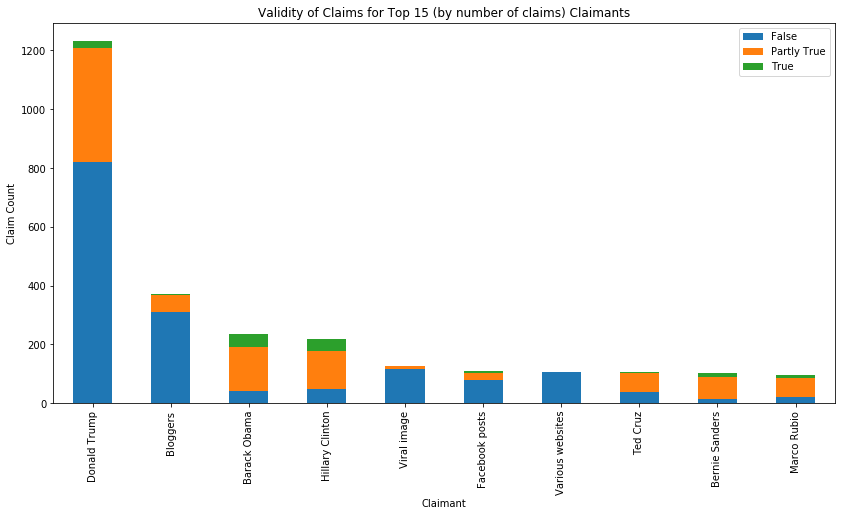

In [25]:
#Prepares dataframe with indices and values for plotting
claimant_df = pd.DataFrame(index=top_10_clm,  data=data_list, columns=['False', 'Partly True', 'True'])
#After checking df, some of the sources have only false entries, so we can fill missing indices (True/Partly) with 0's
claimant_df.fillna(0, inplace=True)
ax = claimant_df.plot(kind="bar", stacked=True, figsize=(14,7), title= 'Validity of Claims for Top 15 (by number of claims) Claimants')
plt.xlabel('Claimant')
plt.ylabel('Claim Count')

#### Claimants as Features
We will dummy encode all of the different claimants at section 3. The graph is above is a visualization of the observed trends for top 10 claimants

#### Gender (Classifier also implicitly checks for isPerson)

In [26]:
#Takes the first word in claimant string, and checks if it is a name, and if it is then assigns a gender 
#If claimant is missing or classified as other/unknown, we distinguish between these cases
def gender_recog(claimant):
    g_d = gender.Detector()
    if claimant == "Unknown":
        return 0
    elif claimant == "Other":
        return 1
    elif claimant == "nan":
        return -1
    else:
        gen_class = g_d.get_gender(claimant.split()[0])
    if gen_class in ["unknown"]:
        return 2
    if gen_class in ["mostly_female", "female"]:
        return 3
    if gen_class in ["mostly_male", "male"]:
        return 4

In [27]:
%%time
#Gender classifier runs through all the claimant data
gender_list = []
i = 0
for claimant in data['claimant']:
    gender_num = gender_recog(claimant)
    gender_list.append(gender_num) 
    
    # print progress
    i += 1
    progress = round((i/data['claimant'].shape[0])*100,2)
    clear_output(wait=True)
    print("progress: " + str(progress) + "%")

progress: 0.59%


KeyboardInterrupt: 

In [28]:
#Remap the dataframe values for gender to interpretable results
data2 = pd.DataFrame()
data2['gender'] = gender_list
gend = {-1: 'NaN', 0: 'Unknown', 1: 'Other', 2: 'Not Person-Result', 3: 'Female-Result', 4: 'Male-Result'}
data2.replace({'gender': gend}, inplace=True)
#encoding of gender classifier
gender_dum = pd.get_dummies(data2['gender'], prefix = 'gender')

#### isPolitician?

We compiled a large public list of North American politicians, which we then cross reference with our claimants. If the claimant is in the list, then we consider the claimant as a politician.

In [29]:
pol_list = pd.read_csv('us_politicians.csv')
#Amount of claimants recognized as politicians under True value
data.claimant.isin(pol_list['name']).value_counts()

False    12557
True      2998
Name: claimant, dtype: int64

In [30]:
#Add as a feature to dataframe
is_pol = data.claimant.isin(pol_list['name']).astype(int)
data2['isPolitician'] = is_pol
#Retrieves the labels (fake, true, partly true) for claims made by politicians 
comb_data = pd.concat([data['label'], data2['isPolitician']], axis=1, sort=False)
data_list =[]
for num in range(0,2):
    is_pol = comb_data[comb_data['isPolitician'] == num]
    label_count = is_pol.groupby('label').count()['isPolitician'].tolist()
    data_list.append(label_count)

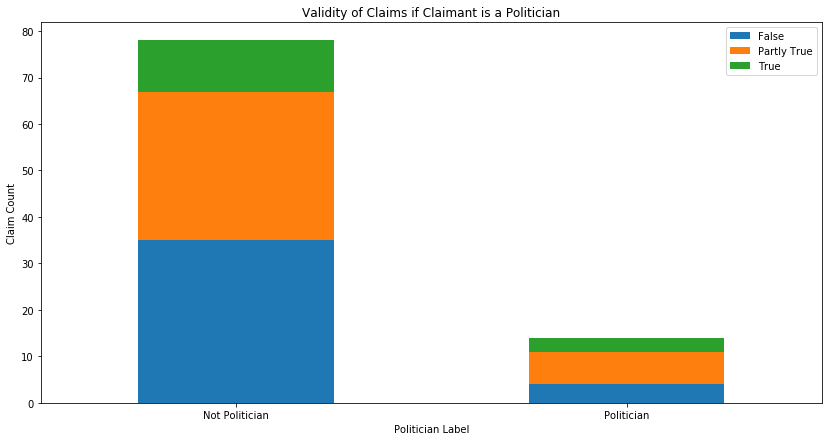

In [31]:
claimant_df = pd.DataFrame(index=['Not Politician', 'Politician'],  data=data_list, columns=['False', 'Partly True', 'True'])
#After checking df, some of the sources have only false entries, so we can fill missing indices (True/Partly) with 0's
claimant_df.fillna(0, inplace=True)
ax = claimant_df.plot(kind="bar", stacked=True, figsize=(14,7), title='Validity of Claims if Claimant is a Politician')
plt.xlabel('Politician Label')
plt.ylabel('Claim Count')
plt.xticks(rotation='horizontal')
plt.show()

In [32]:
#Below we can see the breakdown of the truthfulness of the claims as a fraction for politicians/non-politicians
claimant_df['Total'] = claimant_df.sum(axis=1)
claimant_df['False_fraction'] = claimant_df['False'] / claimant_df['Total']
claimant_df['Partly_true_fraction'] = claimant_df['Partly True'] / claimant_df['Total']
claimant_df['True_fraction'] = claimant_df['True'] / claimant_df['Total']
claimant_df

,False,Partly True,True,Total,False_fraction,Partly_true_fraction,True_fraction
Not Politician,35,32,11,78,0.448718,0.410256,0.141026
Politician,4,7,3,14,0.285714,0.500000,0.214286


In [33]:
#Concatenates the features generated by is_politician and gender classifier
data3 = pd.concat([data2['isPolitician'], gender_dum], axis=1)
data3.head(5)

,isPolitician,gender_Female-Result,gender_Male-Result,gender_Not Person-Result,gender_Unknown
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,1,1,0,0,0


In [34]:
data3.to_pickle('claimant_features.pkl')

### 2.4 Doc2Vec Features

In order for machine learning models to learn, data must be in numerical form. As a result, it is necessary to represent words and sentences as numerical features. To do this, there are several Natural Language Processing techniques such as bag of words or term frequency. However, these methods of encoding words have a flaw in the sense that they create an unique number for every word/sentence which disables the computer from learning association/similarities between similar words/phrases. To solve this problem, *doc2vec* was developed in 2014 by Mikilov and Le as a way to embedd and convert documents into an n-dimensional vector. To achieve this, a doc2vec model must first be trained on the text corpus (With an associated document label). For our application, all the related article sentences as well as the claims are used as training material for our own doc2vec model. With the trained model, we will then be able to obtain the n-dimensional vector for each claim and sentence in our dataset. It is important to note that it is also possible to infer new vectors for previously unseen text data with this model.

In [ ]:
# # read the data
data = pd.read_pickle("./final_data_dates.pkl")
articles = pd.read_pickle('./final_articles.pkl')
# data = final_data
# articles = final_articles

### 2.4.1 Preprocess the Data 

This section preprocesses the claims and related articles data to prepare for Doc2Vec training. To start, a label is generated for every sentence of every related article. For example "125923-5" represents the 5th sentence of article ID 125923.

In [55]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from scipy import spatial
import random

In [56]:
%%time

# 2 minutes to run
# create a label for every sentence based on article ID (eg. 12345-1, 12345-2, 12345-3 ... etc.)

full_sentences_ID = []
for i in range(articles.shape[0]):
    sentence_ID_list = []
    sentence_number = 0
    sentences = articles.tokenized_cleaned_sentence.loc[articles.index[i]]
    for u in range(len(sentences)):
        sentence_ID = str(articles.index[i][0]) +  '-' + str(sentence_number)
        sentence_number += 1
        sentence_ID_list.append(sentence_ID)
    full_sentences_ID.append(sentence_ID_list)
    
    # print progress
    progress = round((i/articles.shape[0])*100,2)
    clear_output(wait=True)
    print("progress: " + str(progress) + "%")

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [58]:
# combine the tokenized sentences with their ID
articles_tok_sent = articles.tokenized_cleaned_sentence.to_frame()
articles_tok_sent['sentence_ID'] = full_sentences_ID
articles_tok_sent.head()

,tokenized_cleaned_sentence,sentence_ID
125923,"[[fact, check, five, pillar, curriculum, fact,...","[125923-0, 125923-1, 125923-2, 125923-3, 12592..."
57270,"[[state, depart, spent, 52701, curtain, un, am...","[57270-0, 57270-1, 57270-2, 57270-3, 57270-4, ..."
144732,"[[us, show, forc, send, russia, messag, black,...","[144732-0, 144732-1, 144732-2, 144732-3, 14473..."
28766,"[[mexico, miss, student, protest, clash, polic...","[28766-0, 28766-1, 28766-2, 28766-3, 28766-4, ..."
85305,"[[us, refuge, resettl, program, primer, policy...","[85305-0, 85305-1, 85305-2, 85305-3, 85305-4, ..."


In [ ]:
# %%time

# # combine the sentence list and index list ~ takes 1.5 hours to run

# article_sent_list = []
# article_sent_ID = []

# for i in range(articles_tok_sent.shape[0]):
#     one_article_sent = articles_tok_sent.tokenized_cleaned_sentence.loc[articles.index[i]]
#     article_sent_list = article_sent_list + one_article_sent
#     one_article_ID = articles_tok_sent.sentence_ID.loc[articles.index[i]]
#     article_sent_ID = article_sent_ID + one_article_ID
    
#     # print progress
#     progress = round((i/articles_tok_sent.shape[0])*100,2)
#     clear_output(wait=True)
#     print("progress: " + str(progress) + "%")

In [ ]:
# # create a data frame of the independent sentences and ID

# # create copies
# l1 = article_sent_list
# l2 = article_sent_ID
# # make dataframe
# article_information = pd.Series(l2).to_frame()
# article_information.columns = ['sentence_ID']
# article_information['sentences'] = l1
# # display it
# article_information.head()

In [ ]:
# # save it to pickle
# article_information.to_pickle("./article_sentences_ind.pkl")

Every sentence of every related article along with the respective ID's are added to the following dataframe for Doc2Vec training.

In [62]:
sentences_pkl = pd.read_pickle("./article_sentences_ind.pkl")
# sentences_pkl = article_information
sentences_pkl.head()

,sentence_ID,sentences
0,125385-0,"[dr, ben, carson, welfar, benefactor]"
1,125385-1,"[initi, unlik, clearli, formid, contend, 2016,..."
2,125385-2,"[unlik, chri, christi, rand, paul, mike, hucka..."
3,125385-3,"[carson, becam, somewhat, overnight, sensat, f..."
4,125385-4,"[earliest, version, meme, date, least, decemb,..."


In [63]:
# extract the lists from the dataframes
sentence_ID_list = sentences_pkl.sentence_ID.tolist()
sentence_list = sentences_pkl.sentences.tolist()

### 2.4.2 Prepare for Training

The related article sentences along with the claims are added together with their ID's in this section for Doc2Vec training.

In [66]:
%%time
    
# create a list of claim index ranging from 0 - 15554
claim_range = range(0, 15555)
claim_index = []
for i in claim_range:
    claim_index.append(i)

# create a list of lists of data.tokenized_claim
tokenized_claims = []
for i in range(data.shape[0]):
    tokenized_claims.append(data.tokenized_claim[i])
    
# convert claim index to string to match the sentences ID
claim_str_index = list(map(str, claim_index))

# form full list for training
full_text_list = sentence_list + tokenized_claims
full_ID_list = sentence_ID_list + claim_str_index

CPU times: user 450 ms, sys: 4 µs, total: 450 ms
Wall time: 449 ms


In [67]:
# combine above 2 lists in to a dictionary for debugging
complete_data = dict(zip(full_ID_list, full_text_list))

### 2.4.3 Doc2Vec Training 

The code to enable Doc2Vec training is implemented below. Some key parameters are a vector size of 150 and 30 epochs.

In [ ]:
# %%time

# #create tagged data to train doc2vec w claim
# tagged_data = [TaggedDocument(words=full_text_list[i], tags=[full_ID_list[i]]) for i in range(len(full_text_list))]

In [ ]:
# %%time

# # 6 hours to run

# import multiprocessing
# n_cpu = multiprocessing.cpu_count()

# # setup training
# vec_size = 150
# model = Doc2Vec(dm = 1, vector_size = vec_size, min_count = 2, workers = n_cpu, epochs=30)

# # build vocab
# model.build_vocab(tagged_data)

# # train
# model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

# # save model
# model.save("30epoch_150vec.model")
# print("Model Saved")

### 2.4.4 Find Cosine Similarities 

In this section, similarities between claims and its related article sentences are calculated using *Cosine similarity*. This is a measure of how similar two vectors are by comparing the cosine angle between them. In our specific application, we are using the 150 dimensional vector that is generated for each claim and related article sentence. As an example, the Cosine distance between *u* and *v* is defined below. This is implemented with a SciPy function: *scipy.spatial.distance.cosine*

$$
1-\frac{u \cdot v}{\|u\|_{2}\|v\|_{2}}
$$

In [68]:
%%time

# load the model
model = Doc2Vec.load("30epoch_150vec.model")

CPU times: user 14 s, sys: 2.51 s, total: 16.5 s
Wall time: 19.9 s


### 2.4.4.1 Finding Top 5 Sentences per Related Articles per Claim 

Find the top 5 sentences for each related article per claim. For example, Claim 0 has 5 related articles. Within each related article, top 5 most similar sentences are extracted. As a result, 25 total sentences are extracted from the 5 related articles. The similarity score of the sentences per related article is averaged, and then the 5 averages are averaged again to create an average similarity score between the claim and the 5 top 5 sentences of each 5 related articles.

In [71]:
%%time

# ~ 6 minutes to run
# find the top 5 sentence ID from each related article with the highest similarity score with the claim

final_best_sentences_ID = []
for i in range(data.shape[0]): # iterating over every claim
    one_claim_array = data.article_array.loc[i]
    best_sentences_one_claim = []
    for u in range(len(one_claim_array)): # iterating every article of one claim
        one_article_ID = one_claim_array[u]
        sent_list = articles.tokenized_cleaned_sentence.loc[str(one_article_ID)].iloc[0]
        one_article_sim_list=[]
        for y in range(len(sent_list)): #iterating over every sentence of one article
            v1 = model.docvecs[str(i)]
            sentence_number = str(str(one_article_ID) + '-' + str(y))
            v2 = model.docvecs[sentence_number]
            similarity = 1 - spatial.distance.cosine(v1, v2)
            one_article_sim_list.append(similarity)
#             print("ID: " + str(i) + " " + str(result))
        a = numpy.array(one_article_sim_list)
        best_sentences_one_article = heapq.nlargest(5, range(len(a)), a.take)   
        best_sentences_one_claim.append(best_sentences_one_article)
    final_best_sentences_ID.append(best_sentences_one_claim)
    # print progress
    progress = round((i/data.shape[0])*100,2)
    clear_output(wait=True)
    print("progress: " + str(progress) + "%")

# add it to the data frame
data['best_sentences_ID'] = final_best_sentences_ID

progress: 99.99%
CPU times: user 6min 1s, sys: 7.29 s, total: 6min 8s
Wall time: 6min 2s


In [72]:
%%time

# ~ 2 minuts to run
# calculate the top 5 similarity scores

end = data.shape[0]
# end = 2
avg_sim_for_one_claim_list = []
avg_sim_one_claim = []
full_sentence_ID = []
for i in range(end): # per row
    one_claim_articles_ID = data.article_array.loc[i]
    one_claim_sentences_ID = data.best_sentences_ID.loc[i]
    avg_sim_for_one_article = []
    article_sentence_ID = []
#     print("claim: " + str(i))
    for u in range(len(one_claim_articles_ID)): # article_array index
        sim_for_one_article = []
        sentence_ID_list = []
        for y in range(len(one_claim_sentences_ID[u])): # sentence ID index      
            sentence_ID = str(one_claim_articles_ID[u]) + '-' + str(data.best_sentences_ID.loc[i][u][y])
            sentence_ID_list.append(sentence_ID)
            # calculate sim score
            v1 = model.docvecs[str(i)]
            v2 = model.docvecs[sentence_ID]
            similarity = 1 - spatial.distance.cosine(v1, v2)
            # similarity between claim and each sentence is calculated
            sim_for_one_article.append(similarity)
#             print(str(sentence_ID) + ": " + str(similarity))
        # the similarity between claim and each sentence per article is averaged
        avg_sim = sum(sim_for_one_article)/len(sim_for_one_article)
        avg_sim_for_one_article.append(avg_sim)
#         print("")
        article_sentence_ID.append(sentence_ID_list)
    
    # create a list of sentence ID's
    full_sentence_ID.append(article_sentence_ID)
    
    #calculate average scores for each claim
    avg_sim_ = sum(avg_sim_for_one_article)/len(avg_sim_for_one_article)
    avg_sim_one_claim.append(avg_sim_)
    
    # a list of lists, big list per claim, and small list per article
    avg_sim_for_one_claim_list.append(avg_sim_for_one_article)
    
    # print progress
    progress = round((i/end)*100,2)
    clear_output(wait=True)
    print("progress: " + str(progress) + "%")

progress: 99.99%
CPU times: user 1min 9s, sys: 2.65 s, total: 1min 11s
Wall time: 1min 9s


In [74]:
# add to data frame
data['full_sentence_ID'] = full_sentence_ID
data['avg_sentence_sim'] = avg_sim_for_one_claim_list
data['avg_sim_score'] = avg_sim_one_claim

In [75]:
data.head()

,raw_claim,cleaned_claim,stemmed_claims,stemmed_stopword_claims,tokenized_claim,claimant,label,article_array,new_date,cont_days,Year,Month,best_sentences_ID,full_sentence_ID,avg_sentence_sim,avg_sim_score
0,A line from George Orwell's novel 1984 predict...,a line from george orwells novel 1984 predicts...,a line from georg orwel novel 1984 predict the...,line georg orwel novel 1984 predict power smar...,"[line, georg, orwel, novel, 1984, predict, pow...",Unknown,0,"[122094, 122580, 130685, 134765]",2017-07-17,11520,2017,7,"[[0, 21, 15, 20, 10], [11, 24, 12, 13, 26], [3...","[[122094-0, 122094-21, 122094-15, 122094-20, 1...","[0.26672267615795137, 0.24059542417526245, 0.1...",0.185311
1,Maine legislature candidate Leslie Gibson insu...,maine legislature candidate leslie gibson insu...,main legislatur candid lesli gibson insult par...,main legislatur candid lesli gibson insult par...,"[main, legislatur, candid, lesli, gibson, insu...",Unknown,2,"[106868, 127320, 128060]",2018-03-17,11763,2018,3,"[[11, 7, 13, 3, 4], [22, 24, 0, 1, 19], [0, 8,...","[[106868-11, 106868-7, 106868-13, 106868-3, 10...","[0.382437926530838, 0.374161022901535, 0.28886...",0.348489
2,A 17-year-old girl named Alyssa Carson is bein...,a 17yearold girl named alyssa carson is being ...,a 17yearold girl name alyssa carson is be trai...,17yearold girl name alyssa carson train nasa b...,"[17yearold, girl, name, alyssa, carson, train,...",Unknown,1,"[132130, 132132, 149722]",2018-07-18,11886,2018,7,"[[22, 30, 8, 32, 29], [3, 6, 59, 60, 83], [6, ...","[[132130-22, 132130-30, 132130-8, 132130-32, 1...","[0.45887559056282046, 0.6421806216239929, 0.29...",0.464089
3,In 1988 author Roald Dahl penned an open lette...,in 1988 author roald dahl penned an open lette...,in 1988 author roald dahl pen an open letter u...,1988 author roald dahl pen open letter urg par...,"[1988, author, roald, dahl, pen, open, letter,...",Unknown,2,"[123254, 123418, 127464]",2019-02-04,12087,2019,2,"[[51, 41, 70, 103, 30], [107, 102, 61, 191, 98...","[[123254-51, 123254-41, 123254-70, 123254-103,...","[0.7696409344673156, 0.7453237056732178, 0.755...",0.756903
4,"When it comes to fighting terrorism, ""Another ...",when it comes to fighting terrorism another th...,when it come to fight terror anoth thing we kn...,come fight terror anoth thing know doe work ba...,"[come, fight, terror, anoth, thing, know, doe,...",Hillary Clinton,2,"[41099, 89899, 72543, 82644, 95344, 88361]",2016-03-22,11038,2016,3,"[[168, 170, 45, 191, 32], [10, 12, 4, 16, 25],...","[[41099-168, 41099-170, 41099-45, 41099-191, 4...","[0.4999494135379791, 0.408842134475708, 0.3396...",0.411560


### 2.4.4.2 Finding Top 5 Sentences Amongst all Related Articles per Claim

In this section, instead of finding top 5 sentences from each related article, the top 5 sentences from ALL related articles of a claim is extracted. The average similarity score between the claim and the top 5 sentences are calculated and added as a feature.

In [76]:
%%time

# 1 min to run
# finding top 5 sentences amongst all relateld articles per claim

end = data.shape[0]
# end = 10

sim_score_dict = {}

final_top_sentences = []

for i in range(end):
    top_sentence_list = data.full_sentence_ID.loc[i]
    sim_score_tuple = []
    for u in range(len(top_sentence_list)):
        for y in range(len(top_sentence_list[u])):
            sentence_ID = top_sentence_list[u][y]
            # calculate sim score
            v1 = model.docvecs[str(i)]
            v2 = model.docvecs[sentence_ID]
            similarity = 1 - spatial.distance.cosine(v1, v2)
#             sim_for_one_claim.append(similarity)
            sim_score_tuple.append(tuple((sentence_ID, similarity)))
#             print(str(sentence_ID) + ": " + str(similarity))
    a = nlargest(5, sim_score_tuple, key=itemgetter(1))
    top_sentences = [q[0] for q in a]
    # list of lists: final top 5 sentences amongst all related articles per claim
    final_top_sentences.append(top_sentences)
    
    # print progress
    progress = round((i/end)*100,2)
    clear_output(wait=True)
    print("progress: " + str(progress) + "%")

# save it to the dataframe
data['top_5_sentences'] = final_top_sentences

progress: 99.99%
CPU times: user 50.7 s, sys: 3.26 s, total: 54 s
Wall time: 51 s


In [77]:
%%time

# average similarity scores of top 5 sentences amongst all relateld articles per claim

end = data.shape[0]
# end = 10

total_avg_sim = []

for i in range(end):
    top_sentence_list = data.top_5_sentences.loc[i]
    top_sim_scores = []
    for u in range(len(top_sentence_list)):
        sentence_ID = top_sentence_list[u]
        # calculate sim score
        v1 = model.docvecs[str(i)]
        v2 = model.docvecs[sentence_ID]
        similarity = 1 - spatial.distance.cosine(v1, v2)       
        top_sim_scores.append(similarity)
        
    avg_sim = sum(top_sim_scores)/len(top_sim_scores)
    total_avg_sim.append(avg_sim)
    
    # print progress
    progress = round((i/end)*100,2)
    clear_output(wait=True)
    print("progress: " + str(progress) + "%")

# save it to the dataframe
data['top5_avg_sim'] = total_avg_sim

progress: 95.2%


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [78]:
data.head()

,raw_claim,cleaned_claim,stemmed_claims,stemmed_stopword_claims,tokenized_claim,claimant,label,article_array,new_date,cont_days,Year,Month,best_sentences_ID,full_sentence_ID,avg_sentence_sim,avg_sim_score,top_5_sentences,top5_avg_sim
0,A line from George Orwell's novel 1984 predict...,a line from george orwells novel 1984 predicts...,a line from georg orwel novel 1984 predict the...,line georg orwel novel 1984 predict power smar...,"[line, georg, orwel, novel, 1984, predict, pow...",Unknown,0,"[122094, 122580, 130685, 134765]",2017-07-17,11520,2017,7,"[[0, 21, 15, 20, 10], [11, 24, 12, 13, 26], [3...","[[122094-0, 122094-21, 122094-15, 122094-20, 1...","[0.26672267615795137, 0.24059542417526245, 0.1...",0.185311,"[122094-0, 122580-11, 122094-21, 122094-15, 12...",0.291527
1,Maine legislature candidate Leslie Gibson insu...,maine legislature candidate leslie gibson insu...,main legislatur candid lesli gibson insult par...,main legislatur candid lesli gibson insult par...,"[main, legislatur, candid, lesli, gibson, insu...",Unknown,2,"[106868, 127320, 128060]",2018-03-17,11763,2018,3,"[[11, 7, 13, 3, 4], [22, 24, 0, 1, 19], [0, 8,...","[[106868-11, 106868-7, 106868-13, 106868-3, 10...","[0.382437926530838, 0.374161022901535, 0.28886...",0.348489,"[106868-11, 106868-7, 127320-22, 127320-24, 12...",0.400307
2,A 17-year-old girl named Alyssa Carson is bein...,a 17yearold girl named alyssa carson is being ...,a 17yearold girl name alyssa carson is be trai...,17yearold girl name alyssa carson train nasa b...,"[17yearold, girl, name, alyssa, carson, train,...",Unknown,1,"[132130, 132132, 149722]",2018-07-18,11886,2018,7,"[[22, 30, 8, 32, 29], [3, 6, 59, 60, 83], [6, ...","[[132130-22, 132130-30, 132130-8, 132130-32, 1...","[0.45887559056282046, 0.6421806216239929, 0.29...",0.464089,"[132132-3, 132132-6, 132132-59, 132132-60, 132...",0.642181
3,In 1988 author Roald Dahl penned an open lette...,in 1988 author roald dahl penned an open lette...,in 1988 author roald dahl pen an open letter u...,1988 author roald dahl pen open letter urg par...,"[1988, author, roald, dahl, pen, open, letter,...",Unknown,2,"[123254, 123418, 127464]",2019-02-04,12087,2019,2,"[[51, 41, 70, 103, 30], [107, 102, 61, 191, 98...","[[123254-51, 123254-41, 123254-70, 123254-103,...","[0.7696409344673156, 0.7453237056732178, 0.755...",0.756903,"[127464-222, 123254-51, 123254-41, 123254-70, ...",0.775002
4,"When it comes to fighting terrorism, ""Another ...",when it comes to fighting terrorism another th...,when it come to fight terror anoth thing we kn...,come fight terror anoth thing know doe work ba...,"[come, fight, terror, anoth, thing, know, doe,...",Hillary Clinton,2,"[41099, 89899, 72543, 82644, 95344, 88361]",2016-03-22,11038,2016,3,"[[168, 170, 45, 191, 32], [10, 12, 4, 16, 25],...","[[41099-168, 41099-170, 41099-45, 41099-191, 4...","[0.4999494135379791, 0.408842134475708, 0.3396...",0.411560,"[41099-168, 95344-259, 95344-247, 95344-74, 95...",0.547029


In [ ]:
# # save to data frame
data.to_pickle("./data_sentence_simscore.pkl")

### 2.4.5 Feature Encoding

In this section, the claims, related article sentences and similarity scores are encoded in to numerical values for our fake news classfication model.

In [79]:
# # load the files
full_data = pd.read_pickle("./data_sentence_simscore.pkl")
# full_data = data

### 2.4.5.1 Feature Encode the Claims

This section applies the trained Doc2Vec model to generate a vector of size 150 for each claim.

In [80]:
# create a list of lists containing the claim's vector
claim_vectors = []
for i in range(0, 15555):
    claim_vectors.append(model.docvecs[str(i)])

# create a list of column names
column_name_list = []
for i in range(0,150):
    column_name = "claim_vec_" + str(i)
    column_name_list.append(column_name)

# turn the claim vectors in to a dataframe and rename the columns accordingly
claim_features = pd.DataFrame.from_records(claim_vectors)
claim_features.columns = column_name_list

In [81]:
claim_features.head()

,claim_vec_0,claim_vec_1,claim_vec_2,claim_vec_3,claim_vec_4,claim_vec_5,claim_vec_6,claim_vec_7,claim_vec_8,claim_vec_9,...,claim_vec_140,claim_vec_141,claim_vec_142,claim_vec_143,claim_vec_144,claim_vec_145,claim_vec_146,claim_vec_147,claim_vec_148,claim_vec_149
0,-0.212091,0.127670,0.106502,0.391641,0.303139,-0.248252,0.236494,0.104728,-0.271278,0.377465,...,-0.283741,-0.166108,-0.125862,0.316487,-0.086704,-0.015346,0.263394,0.236137,0.191386,-0.144861
1,0.512708,0.203220,0.151913,-0.307748,-0.426895,0.143223,0.293944,-0.129267,0.512433,0.322509,...,-0.216366,0.181766,0.237602,0.279045,-0.126447,-0.209171,-0.191039,0.158190,-0.066281,-0.247980
2,0.145354,0.215115,0.078994,0.009343,0.213732,-0.022070,0.126207,-0.130475,-0.093990,0.159534,...,-0.155529,-0.015081,0.274674,0.272769,-0.237696,0.130785,-0.032134,0.104650,0.257081,0.016224
3,-0.138208,0.415532,-0.018799,0.094876,0.292537,-0.157601,0.552872,-0.179123,0.080213,-0.131668,...,-0.336580,-0.263726,-0.080669,0.152311,-0.093220,0.300876,-0.068453,0.307259,0.150425,-0.206309
4,0.126634,0.311318,-0.125836,-0.143917,-0.092023,-0.118011,-0.178362,-0.358138,0.349950,-0.148357,...,-0.029561,-0.171704,0.290350,0.440742,-0.249992,0.430053,-0.086707,0.252833,-0.295727,0.226280


### 2.4.5.2 Feature Encode the Top 5 Related Article Sentences for Each Claim

In thi section, the top 5 sentences from all related articles per claim are encoded by using the Doc2Vec model to generate a vector for each sentence. (5 sentences, 150 vectors each, 750 columns of features in total).

In [82]:
%%time

end = full_data.shape[0]
# end = 1
full_sentence_vector_list = []
for i in range(end):
    top_5_sentences = full_data.top_5_sentences.loc[i]
    sentence_vector_list = []
    for u in range(len(top_5_sentences)):
        sentence_ID = full_data.top_5_sentences.loc[i][u]
        sentence_vector = model.docvecs[sentence_ID]
        sentence_vector_list.extend(sentence_vector)
    full_sentence_vector_list.append(sentence_vector_list)

    # print progress
    progress = round((i/end)*100,2)
    clear_output(wait=True)
    print("progress: " + str(progress) + "%")

# create column names
complete_column_name=[]
for i in range(1, 6):
    column_name_list = []
    for u in range(0,150):
        column_name = "sent_" + str(i) + "vec_" + str(u)
        column_name_list.append(column_name)
    complete_column_name.extend(column_name_list)

# convert full sentence features in to dataframe and name the columns accordingly
sentence_features = pd.DataFrame.from_records(full_sentence_vector_list)
sentence_features.columns = complete_column_name

progress: 99.99%
CPU times: user 24.3 s, sys: 2.6 s, total: 26.9 s
Wall time: 23.9 s


In [83]:
sentence_features.head()

,sent_1vec_0,sent_1vec_1,sent_1vec_2,sent_1vec_3,sent_1vec_4,sent_1vec_5,sent_1vec_6,sent_1vec_7,sent_1vec_8,sent_1vec_9,...,sent_5vec_140,sent_5vec_141,sent_5vec_142,sent_5vec_143,sent_5vec_144,sent_5vec_145,sent_5vec_146,sent_5vec_147,sent_5vec_148,sent_5vec_149
0,0.010075,-0.034665,0.158326,0.114454,0.167062,-0.325514,0.343727,-0.181544,0.427879,-0.064174,...,-0.329464,-0.123360,-0.106719,0.596236,-0.361782,-0.154024,0.078335,0.041940,-0.059460,0.239629
1,0.537097,0.346272,-0.127193,0.008937,-0.498761,0.209842,-0.136562,-0.121760,0.598921,0.272825,...,0.310716,1.026762,1.642795,0.402427,-0.656952,-0.680550,1.451327,0.068513,0.286796,0.028587
2,-0.034549,0.159652,0.068537,-0.108595,0.401951,0.025913,0.490867,-0.182542,0.126992,0.227730,...,-0.187836,-0.225113,0.046499,0.118527,0.053234,0.126584,-0.112338,0.300140,0.125310,0.023155
3,-0.006104,0.218761,-0.044763,-0.014197,0.140955,0.030794,0.227532,-0.064394,0.077120,0.073692,...,-0.184586,-0.138933,0.027737,0.214644,-0.101030,0.155582,0.019132,0.178928,0.125431,0.017242
4,0.143222,0.262105,-0.407402,-0.173036,-0.196569,0.068167,0.154569,-0.175273,0.005277,0.168737,...,-0.060368,-0.066583,0.038418,0.146584,-0.051212,0.113704,-0.006178,0.114713,0.056479,0.011474


### 2.4.5.3 Feature Encode the Similarity Scores

The average similarity scores are appended here.

In [84]:
sim_score_features = pd.concat([full_data.avg_sim_score, full_data.top5_avg_sim], axis=1)
sim_score_features.columns = ["avg_sent_sim", "avg_5_sent_sim"]

### 2.4.6 Combine All Features (Claim Vector, Top 5 Related Sentence Vector, Similarity Scores)

This section combines all features mentioned above in to one complete dataframe.

In [85]:
final_similiarity_sentences_features = pd.concat([claim_features, sentence_features, sim_score_features], axis=1)

In [87]:
# replace nan values with zero
final_similiarity_sentences_features.fillna(0, inplace = True)

In [89]:
# save the final features to a pickle
final_similiarity_sentences_features.to_pickle("./doc2vec_features.pkl")

In [90]:
final_similiarity_sentences_features.head()

,claim_vec_0,claim_vec_1,claim_vec_2,claim_vec_3,claim_vec_4,claim_vec_5,claim_vec_6,claim_vec_7,claim_vec_8,claim_vec_9,...,sent_5vec_142,sent_5vec_143,sent_5vec_144,sent_5vec_145,sent_5vec_146,sent_5vec_147,sent_5vec_148,sent_5vec_149,avg_sent_sim,avg_5_sent_sim
0,-0.212091,0.127670,0.106502,0.391641,0.303139,-0.248252,0.236494,0.104728,-0.271278,0.377465,...,-0.106719,0.596236,-0.361782,-0.154024,0.078335,0.041940,-0.059460,0.239629,0.185311,0.291527
1,0.512708,0.203220,0.151913,-0.307748,-0.426895,0.143223,0.293944,-0.129267,0.512433,0.322509,...,1.642795,0.402427,-0.656952,-0.680550,1.451327,0.068513,0.286796,0.028587,0.348489,0.400307
2,0.145354,0.215115,0.078994,0.009343,0.213732,-0.022070,0.126207,-0.130475,-0.093990,0.159534,...,0.046499,0.118527,0.053234,0.126584,-0.112338,0.300140,0.125310,0.023155,0.464089,0.642181
3,-0.138208,0.415532,-0.018799,0.094876,0.292537,-0.157601,0.552872,-0.179123,0.080213,-0.131668,...,0.027737,0.214644,-0.101030,0.155582,0.019132,0.178928,0.125431,0.017242,0.756903,0.775002
4,0.126634,0.311318,-0.125836,-0.143917,-0.092023,-0.118011,-0.178362,-0.358138,0.349950,-0.148357,...,0.038418,0.146584,-0.051212,0.113704,-0.006178,0.114713,0.056479,0.011474,0.411560,0.547029


## 2.5 Sentiment Features 

In [39]:
data = pd.read_pickle('./final_data.pkl')

In this section, the sentiment scores of the raw text of each claim is calculated and saved to the 'data' dataframe. The scores are categorized as positive, negative, neutral and overall sentiment scores. These scores are saved to the 'data' dataframe.

In [40]:
%%time

sentiment = SentimentIntensityAnalyzer()

vs_compound = []
vs_pos = []
vs_neu = []
vs_neg = []

#applying the sentiment analyzer to the claim text
for i in range(0, len(data)):
    vs_compound.append(sentiment.polarity_scores(data.iloc[i]['raw_claim'])['compound'])
    vs_pos.append(sentiment.polarity_scores(data.iloc[i]['raw_claim'])['pos'])
    vs_neu.append(sentiment.polarity_scores(data.iloc[i]['raw_claim'])['neu'])
    vs_neg.append(sentiment.polarity_scores(data.iloc[i]['raw_claim'])['neg'])
    
#creating new columns with the claim sentiment scores
data['overall'] = vs_compound
data['positive'] = vs_pos
data['neutral'] = vs_neu
data['negative'] = vs_neg

CPU times: user 34.1 s, sys: 57 ms, total: 34.1 s
Wall time: 34.1 s


In [42]:
# delete unecessary columns
del data['raw_claim']
del data['cleaned_claim']
del data['stemmed_claims']
del data['stemmed_stopword_claims']
del data['claimant']
del data['tokenized_claim']
del data['label']
del data['article_array']
del data['new_date']

In [43]:
# display sentiment features
data.head()

,overall,positive,neutral,negative
0,0.3182,0.187,0.813,0.000
1,-0.2023,0.133,0.691,0.176
2,0.0000,0.000,1.000,0.000
3,0.0000,0.000,1.000,0.000
4,-0.7964,0.000,0.738,0.262


In [44]:
# save to pickle
data.to_pickle('sentiment_features.pkl')

## 2.6 Parts of Speech Features

### 2.6.1 Top Words and Frequency of the Words from All Related Articles per Claim

In this section, the top words from all the related articles for a specific claim is calculated along with the frequency occurrance of each word. The number of top words is equal to the number of words in the raw text of each claim.

In [47]:
# read pickle
data = pd.read_pickle('./final_data.pkl')
articles = pd.read_pickle('./final_articles.pkl')

In [48]:
%%time

from collections import Counter

data['top_words_article'] = ''
data['freq_article'] = ''

# finding top words from all related articles per claim
for i in range(len(data)):
    str1 = []
    for j in range(len(data.article_array[i])):
        temp = articles.tokenized_articles.loc[str(data.article_array[i][j])].iloc[0]
        str1 += temp
    key_list = []
    value_list = []
    c = Counter(str1)
    com = c.most_common()
    comm = dict(com[0:len(data.tokenized_claim[i])])
    for keys in dict(comm):
        key_list.append(keys)
        value_list.append(comm[keys])
    data.at[i, 'top_words_article'] = key_list
    data.at[i, 'freq_article'] = value_list
    clear_output(wait=True)
    
    # print progress
    print(str(round((i/len(data))*100, 2))+'%')

99.99%
CPU times: user 1min 8s, sys: 4.17 s, total: 1min 12s
Wall time: 1min 8s


### 2.6.2 Weighted Sum of Overlapping Words between Claim and Related Articles

Looking at the presence of top words from the related articles from each claim in that specific claim, a weighted sum of words is calculated for each claim by adding the frequencies of those overlapping words divided by the number of words in that claim.

In [49]:
%%time

data['weighted_sum'] = ''
for i in range(len(data)):
    w_sum = 0
    j = 0
    for word in (data.tokenized_claim[i]):
        if word in data.top_words_article[i]:
            w_sum += (data.freq_article[i][data.top_words_article[i].index(word)])/len(data.tokenized_claim[i])
    data.at[i, 'weighted_sum'] = w_sum
    clear_output(wait=True)
    
    #print progress
    print(str(round((i/len(data))*100, 2))+'%')

97.37%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### 2.6.3 Number of Words per Claim

The number of words in each claim is calculated and saved to the 'data' dataframe

In [50]:
%%time

# Counting number of words in claim
data['num_words_claim'] = ''
for i in range(len(data)):
    str1 = data.raw_claim[i]
    words = str1.split(' ')
    data.at[i, 'num_words_claim'] = len(words)
    clear_output(wait=True)
    print(str(round((i/len(data))*100, 2))+'%')

99.99%
CPU times: user 15.5 s, sys: 1.84 s, total: 17.4 s
Wall time: 14.8 s


### 2.6.4 Number of Stopwords per Claim

The number of stop words in each claim is calculated and saved to the 'data' dataframe

In [51]:
%%time

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
data['num_stop_claim'] = ''
for i in range(len(data)):
    str1 = data.raw_claim[i]
    words = str1.split()
    counter = 0
    for w in words:
        if w in stop_words:
            counter += 1
    data.at[i, 'num_stop_claim'] = counter
    clear_output(wait=True)
    print(str(round((i/len(data))*100, 2))+'%')

99.99%
CPU times: user 14.6 s, sys: 1.48 s, total: 16.1 s
Wall time: 14 s


### 2.6.5 Number of Special Characters per Claim

The number of special characters in each claim is calculated and saved to the 'data' dataframe

In [52]:
%%time

data['num_special_claim'] = ''
for i in range(len(data)):
    counter = 0
    for c in data.raw_claim[i]:
        if c in '[@_!#$%^&*()<>?/\|}{~:;+=-`]':
            counter += 1
    data.at[i, 'num_special_claim'] = counter
    clear_output(wait=True)
    print(str(round((i/len(data))*100, 2))+'%')

98.75%


### 2.6.6 Number of Characters per Claim

The number of characters in each claim is calculated and saved to the 'data' dataframe

In [53]:
%%time

# Counting number of characters in claim
data['num_char_claim'] = ''
for i in range(len(data)):
    data.at[i, 'num_char_claim'] = len(data.raw_claim[i])
    clear_output(wait=True)
    print(str(round((i/len(data))*100, 2))+'%')

99.99%
CPU times: user 14.7 s, sys: 1.33 s, total: 16.1 s
Wall time: 14.2 s


In [56]:
# deleting unecessary feature columns
del data['raw_claim']
del data['top_words_article']
del data['freq_article']
del data['cleaned_claim']
del data['stemmed_claims']
del data['stemmed_stopword_claims']
del data['claimant']
del data['tokenized_claim']
del data['label']
del data['article_array']
del data['new_date']

In [57]:
# showing the features created in this section
data.head()

,weighted_sum,num_words_claim,num_stop_claim,num_special_claim,num_char_claim
0,4.625,12,3,0,73
1,4.78571,15,1,0,117
2,8.11111,15,5,2,87
3,13.3333,18,5,0,113
4,9.15385,22,9,0,129


In [58]:
# save to pickle
data.to_pickle('pos_features.pkl')

## 2.7 Linguistic Features using Spacy

In this section, the NLP library, 'SPACY' is used for feature engineering on the claims.

In [2]:
data = pd.read_pickle('./final_data.pkl')

### 2.7.1 Claimant Groups

The claimants are categorized into the following groups: 

    - PERSON - People, including fictional
    - ORG - Companies, agencies, institutions
    - NORP - Nationalities or religious or political groups
    - GPE - Countries, cities, states
    - CARDINAL - Numerals that do not fall under another type
    - FAC - Buildings, airports, highways, bridges
    - DATE - Absolute or relative dates or periods
    - LOC - Non-GPE locations, mountain ranges, bodies of water
    - WORK_OF_ART - Titles of books, songs
    - PERCENT - Percentage, including ”%“
    - ORDINAL - “first”, “second”
    - PRODUCT - Objects, vehicles, foods

In [3]:
%%time

import spacy
ner = spacy.load('en_core_web_sm')
data['claimant_group'] = ''
for i in range(len(data)):
    text = data.claimant[i]
    doc = ner(text)
    for ent in doc.ents:
        data.at[i, 'claimant_group'] = ent.label_
    clear_output(wait=True)
    print(str(round((i/len(data))*100, 2))+'%')

99.99%
CPU times: user 2min 31s, sys: 7.07 s, total: 2min 38s
Wall time: 2min 32s


### 2.7.2 Noun Phrases, Verbs, Nouns, Adjectives and Punctuations on Claims

A list of noun phrases, verbs, nouns and adjectives are created for each claim

In [61]:
%%time

import spacy
ner = spacy.load('en_core_web_sm')
data['noun_phrases_claim'] = ''
data['verbs_claim'] = ''
data['nouns_claim'] = ''
data['punct_claim'] = ''
data['adj_claim'] = ''
for i in range(len(data)):
    text = data.raw_claim[i]
    doc = ner(text)
    noun_phrases_list = []
    verbs_list = []
    nouns_list = []
    punct_list = []
    adj_list = []
    for chunk in doc.noun_chunks:
        noun_phrases_list.append(chunk.text)
    for token in doc:
        if token.pos_== 'VERB':
            verbs_list.append(token.lemma_)
        if token.pos_ == 'NOUN':
            nouns_list.append(token.lemma_)
        if token.pos_ == 'PUNCT':
            punct_list.append(token.lemma_)
        if token.pos_ == 'ADJ':
            adj_list.append(token.lemma_)
    data.at[i, 'noun_phrases_claim'] = noun_phrases_list
    data.at[i, 'verbs_claim'] = verbs_list
    data.at[i, 'nouns_claim'] = nouns_list
    data.at[i, 'punct_claim'] = punct_list
    data.at[i, 'adj_claim'] = adj_list
    clear_output(wait=True)
    print(str(round((i/len(data))*100, 2))+'%')

99.99%
CPU times: user 4min 47s, sys: 5.79 s, total: 4min 53s
Wall time: 4min 45s


A count of the number of noun phrases, verbs, nouns and adjectives for each claim is determined and added to the 'data' dataframe

In [62]:
%%time

data['num_adj_claim'] = ''
data['num_punct_claim'] = ''
data['num_nouns_claim'] = ''
data['num_verbs_claim'] = ''
for i in range(len(data)):
    data.at[i,'num_adj_claim'] = len(data.adj_claim[i])
    data.at[i,'num_punct_claim'] = len(data.punct_claim[i])
    data.at[i,'num_nouns_claim'] = len(data.nouns_claim[i])
    data.at[i,'num_verbs_claim'] = len(data.verbs_claim[i])

CPU times: user 1.91 s, sys: 1.91 ms, total: 1.92 s
Wall time: 1.92 s


In [65]:
# deleting unecessary feature columns
del data['raw_claim']
del data['cleaned_claim']
del data['stemmed_claims']
del data['stemmed_stopword_claims']
del data['claimant']
del data['tokenized_claim']
del data['label']
del data['article_array']
del data['new_date']
del data['noun_phrases_claim']
del data['verbs_claim']
del data['nouns_claim']
del data['punct_claim']
del data['adj_claim']

In [66]:
# show Linguistic Features
data.head()

,claimant_group,num_adj_claim,num_punct_claim,num_nouns_claim,num_verbs_claim
0,,1,1,3,1
1,,0,1,4,2
2,,1,2,2,3
3,,1,1,5,3
4,PERSON,1,6,5,5


In [67]:
data.to_pickle('spacy_features.pkl')

## 2.8 Combining All Features

In this section, the 5 types of features (Doc2Vec Features, Date Features, Claimant Features, Sentiment Features and POS Features) are concatenated in to a single dataframe.

In [68]:
# read from all feature pickles that were created
df1 = pd.read_pickle('doc2vec_features.pkl')
df2 = pd.read_pickle('date_features.pkl')
df3 = pd.read_pickle('claimant_features.pkl')
df4 = pd.read_pickle('spacy_features.pkl')
df5 = pd.read_pickle('sentiment_features.pkl')
df6 = pd.read_pickle('pos_features.pkl')

# concatenate all features in to single dataframe
all_features_df = pd.concat([df1, df2, df3, df4, df5, df6], axis=1)

# save dataframe with all features to pickle
all_features_df.to_pickle('all_features.pkl')

In [72]:
all_features_df.head()

,claim_vec_0,claim_vec_1,claim_vec_2,claim_vec_3,claim_vec_4,claim_vec_5,claim_vec_6,claim_vec_7,claim_vec_8,claim_vec_9,...,num_verbs_claim,overall,positive,neutral,negative,weighted_sum,num_words_claim,num_stop_claim,num_special_claim,num_char_claim
0,-0.212091,0.127670,0.106502,0.391641,0.303139,-0.248252,0.236494,0.104728,-0.271278,0.377465,...,1,0.3182,0.187,0.813,0.000,4.625,12,3,0,73
1,0.512708,0.203220,0.151913,-0.307748,-0.426895,0.143223,0.293944,-0.129267,0.512433,0.322509,...,2,-0.2023,0.133,0.691,0.176,4.78571,15,1,0,117
2,0.145354,0.215115,0.078994,0.009343,0.213732,-0.022070,0.126207,-0.130475,-0.093990,0.159534,...,3,0.0000,0.000,1.000,0.000,8.11111,15,5,2,87
3,-0.138208,0.415532,-0.018799,0.094876,0.292537,-0.157601,0.552872,-0.179123,0.080213,-0.131668,...,3,0.0000,0.000,1.000,0.000,13.3333,18,5,0,113
4,0.126634,0.311318,-0.125836,-0.143917,-0.092023,-0.118011,-0.178362,-0.358138,0.349950,-0.148357,...,5,-0.7964,0.000,0.738,0.262,9.15385,22,9,0,129


## 3. Feature Encoding and Selection

In this section, the features from before are first encoded then selected to reduce the total amount of features. A correlation plot is then presented for the selected features using an Extra Tree Classifier. The following are the subsections:

    - 3.1 Feature Preparation
    - 3.2 Feature Encoding
    - 3.3 ExtraTreeClassifier for Feature Selection
    - 3.4 Correlation

### 3.1 Feature Preperation

This section prepares the feature for encoding and selection.

In [80]:
# read the necessary pickle files
data = pd.read_pickle("./final_data.pkl")
all_features = pd.read_pickle("./all_features.pkl")
data = pd.concat([data.copy(), all_features.copy()], axis=1, sort=False)

# make backups
feature_df = data.copy()
label = data.label.copy()

Deleting columns from the 'data' dataframe that are not needed as features

In [82]:
# deleting unecessary feature columns
del feature_df['raw_claim']
del feature_df['cleaned_claim']
del feature_df['stemmed_claims']
del feature_df['stemmed_stopword_claims']
del feature_df['tokenized_claim']
del feature_df['label']
del feature_df['article_array']

### 3.2 Feature Encoding

In [84]:
# a copy of feature_df saved as feature_df_encoded
feature_df_encoded = feature_df.copy()

The column that has groups that each claimant is categorized under is one hot encoded

In [86]:
%%time

claimant_group_encode = pd.get_dummies(feature_df_encoded['claimant_group']).copy()
for col in claimant_group_encode.columns:
    claimant_group_encode.rename(columns={col:'claimant_group'+'('+col+')'}, inplace=True)
feature_df_encoded = pd.concat([feature_df_encoded.copy(), claimant_group_encode], axis=1, sort=False)
del feature_df_encoded['claimant_group']

The column that has the claimant name is one hot encoded

In [88]:
%%time

claimant_encode = pd.get_dummies(feature_df_encoded['claimant']).copy()
for col in claimant_encode.columns:
    claimant_encode.rename(columns={col:'claimant'+'('+col+')'}, inplace=True)
feature_df_encoded = pd.concat([feature_df_encoded.copy(), claimant_encode], axis=1, sort=False)
del feature_df_encoded['claimant']

The column that has the date for when the claim was made is one hot encoded

In [90]:
%%time

date_encode = pd.get_dummies(feature_df_encoded['new_date']).copy()
for col in date_encode.columns:
    date_encode.rename(columns={col:'new_date'+'('+str(col)+')'}, inplace=True)
feature_df_encoded = pd.concat([feature_df_encoded.copy(), date_encode], axis=1, sort=False)
del feature_df_encoded['new_date']

CPU times: user 15.3 s, sys: 95.7 ms, total: 15.4 s
Wall time: 15.4 s


### 3.3 ExtraTreesClassifier for Feature Selection

In this section, we perform feature selection by using ExtraTreesClassifier and SelectFromModel. 

For selecting features, extra tree classifier provides a score value for each feature, with the features with higher scores being selected as inputs into the machine learning algorithms.  It works by fitting randomized decision trees (extra-trees) on various sub samples of the dataset and uses gini impurity to discover which features appear at the top of each tree and therefore have a greater relative importance to predict the target variable. 
https://www.geeksforgeeks.org/ml-extra-tree-classifier-for-feature-selection/

In [102]:
# scale the features
scaler = StandardScaler()
feature_df_scaled = scaler.fit_transform(feature_df_encoded.copy())
feature_df_scaled = pd.DataFrame(feature_df_scaled, columns = feature_df_encoded.columns)

In [103]:
feature_df_scaled.head()

,claim_vec_0,claim_vec_1,claim_vec_2,claim_vec_3,claim_vec_4,claim_vec_5,claim_vec_6,claim_vec_7,claim_vec_8,claim_vec_9,...,new_date(2019-04-21 00:00:00),new_date(2019-04-22 00:00:00),new_date(2019-04-23 00:00:00),new_date(2019-04-24 00:00:00),new_date(2019-04-25 00:00:00),new_date(2019-04-26 00:00:00),new_date(2019-04-27 00:00:00),new_date(2019-04-28 00:00:00),new_date(2019-04-29 00:00:00),new_date(2019-04-30 00:00:00)
0,-0.862814,-0.033059,0.525189,1.983345,0.829186,-1.137431,0.175122,0.642200,-1.321907,1.221267,...,-0.008018,-0.035881,-0.024061,-0.033077,-0.026602,-0.025363,-0.01134,-0.01134,-0.028921,-0.026602
1,2.354389,0.296405,0.707601,-1.153063,-2.304551,0.515701,0.424999,-0.317075,1.974386,0.988479,...,-0.008018,-0.035881,-0.024061,-0.033077,-0.026602,-0.025363,-0.01134,-0.01134,-0.028921,-0.026602
2,0.723796,0.348277,0.414693,0.268930,0.445401,-0.182304,-0.304568,-0.322027,-0.576231,0.298126,...,-0.008018,-0.035881,-0.024061,-0.033077,-0.026602,-0.025363,-0.01134,-0.01134,-0.028921,-0.026602
3,-0.534868,1.222271,0.021869,0.652503,0.783677,-0.754627,1.551206,-0.521459,0.156469,-0.935391,...,-0.008018,-0.035881,-0.024061,-0.033077,-0.026602,-0.025363,-0.01134,-0.01134,-0.028921,-0.026602
4,0.640700,0.767805,-0.408087,-0.418365,-0.867082,-0.587446,-1.629290,-1.255342,1.290983,-1.006084,...,-0.008018,-0.035881,-0.024061,-0.033077,-0.026602,-0.025363,-0.01134,-0.01134,-0.028921,-0.026602


Saving the important features that are determined from the ExtraTreesClassifier and SelectFromModel to feature_df_reduced dataframe.

In [104]:
# extratreeclassifier implementation
model_feature_reduction = ExtraTreesClassifier()
model_feature_reduction = model_feature_reduction.fit(feature_df_scaled, label)
important_array = model_feature_reduction.feature_importances_
model = SelectFromModel(model_feature_reduction, prefit=True)
feature_idx = model.get_support()

feature_df_reduced = pd.DataFrame()
for i in range(len(feature_idx)):
    if feature_idx[i] == bool(True):
        col = feature_df_scaled.columns[i]
        feature_df_reduced[col] = feature_df_scaled.iloc[:,i]

In [106]:
feature_df_reduced.head()

,claim_vec_0,claim_vec_1,claim_vec_2,claim_vec_3,claim_vec_4,claim_vec_5,claim_vec_6,claim_vec_7,claim_vec_8,claim_vec_9,...,claimant(Viral image),claimant(Viral meme),claimant(multiple sources),new_date(2016-10-23 00:00:00),new_date(2017-11-06 00:00:00),new_date(2018-10-26 00:00:00),new_date(2019-01-04 00:00:00),new_date(2019-02-14 00:00:00),new_date(2019-04-04 00:00:00),new_date(2019-04-11 00:00:00)
0,-0.862814,-0.033059,0.525189,1.983345,0.829186,-1.137431,0.175122,0.642200,-1.321907,1.221267,...,-0.090729,-0.043218,-0.067235,-0.149262,-0.163915,-0.03931,-0.031068,-0.040122,-0.03931,-0.035881
1,2.354389,0.296405,0.707601,-1.153063,-2.304551,0.515701,0.424999,-0.317075,1.974386,0.988479,...,-0.090729,-0.043218,-0.067235,-0.149262,-0.163915,-0.03931,-0.031068,-0.040122,-0.03931,-0.035881
2,0.723796,0.348277,0.414693,0.268930,0.445401,-0.182304,-0.304568,-0.322027,-0.576231,0.298126,...,-0.090729,-0.043218,-0.067235,-0.149262,-0.163915,-0.03931,-0.031068,-0.040122,-0.03931,-0.035881
3,-0.534868,1.222271,0.021869,0.652503,0.783677,-0.754627,1.551206,-0.521459,0.156469,-0.935391,...,-0.090729,-0.043218,-0.067235,-0.149262,-0.163915,-0.03931,-0.031068,-0.040122,-0.03931,-0.035881
4,0.640700,0.767805,-0.408087,-0.418365,-0.867082,-0.587446,-1.629290,-1.255342,1.290983,-1.006084,...,-0.090729,-0.043218,-0.067235,-0.149262,-0.163915,-0.03931,-0.031068,-0.040122,-0.03931,-0.035881


### 3.6 Correlation

Bar plot of the top 20 correlations coefficient values between features and labels

Text(0, 0.5, 'Correlation Value')

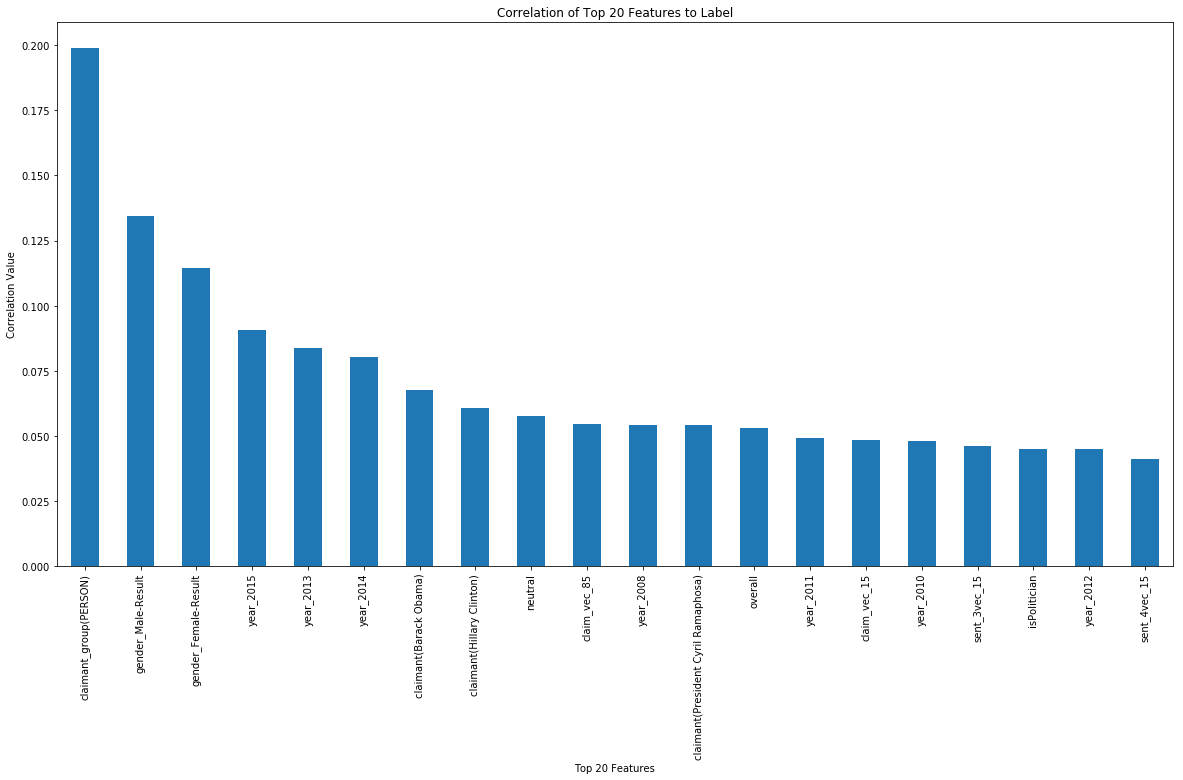

In [123]:
# prepare data for correlation
from sklearn.preprocessing import StandardScaler
correlation_df = feature_df_reduced.copy()
correlation_df = pd.concat([correlation_df.copy(), label], axis=1, sort=False)
# obtain correlation dataframe
corr = correlation_df.corr()
target_row = corr.shape[0]-1
correlation = corr.iloc[target_row,0:target_row].sort_values(ascending=False)
# show top 50 correlations with salary
plt.subplots(figsize=(20,10))
correlation.iloc[0:20].plot(kind='bar')
plt.title('Correlation of Top 20 Features to Label')
plt.xlabel('Top 20 Features')
plt.ylabel('Correlation Value')

## 4. Model Implementation and Tuning

The team used four popular algorithms Logistic Regression, k Nearest Neighbors, Decision Trees, and Support Vector Machine. 

For our model implementation and tuning, we are using an ensembles approach where we train the model using the best 3 algorithms based on accuracy using grid search and cross-validation to obtain the best models from each algorithm. The predictions from each best model is obtained and then the final prediction is determined on a voting system where each data point prediction is the most frequenctly occuring prediction value from the 3 best models.

The following are the subsections:

    - 4.1 Logistic Regression with Grid Search for Hyperparameter Tuning
    - 4.2 k-Nearest Neighbors
    - 4.3 Decision Trees
    - 4.4 Support Vector Machine
    - 4.5 Ensemble Model

In [124]:
# performing test (30%) train (70%) split
X_train, X_test, y_train, y_test = train_test_split(feature_df_reduced, label, random_state=42, test_size=0.3)

### 4.1 Logistic Regression with Grid Search for Hyperparameter Tuning

The team first tried Logistic Regression which is a binary classification algorithm that has been extended for this ordinal (not multinomial) classification task. For a given input, it outputs probabilities for each class, which sum to 1 and the class with the highest probability value is the prediction. It uses the sigmoid function with cross-entropy loss. This classification model is fast to train and simple, and has a convex loss function. However it cannot be applied to non-linear classification and is sensitive to collinearity and outliers.

https://towardsdatascience.com/comparative-study-on-classic-machine-learning-algorithms-24f9ff6ab222

Implementing cross-validation along with grid search on logistic regression over the learning rate. From running grid search it was cocluded that the best learning rate is '0.001'. The best model, which is with learning rate '0.001' was saved and used to predict the 'X_test'.

In [130]:
%%time
# Implementing grid search to calculate best hyperparameters

model = LogisticRegression()
scaler = StandardScaler()
kfold = KFold(n_splits=10)
kfold.get_n_splits(feature_df_reduced)
# all_test_predictions_logistic_list = []
model_logistic_list = []
accuracy_logistic_list = []
best_model = model
best_params = {}
best_accuracy = 0
best_std = 0
i=0
for C in [0.001,0.01,0.05,0.1,0.5,1,5,10, 100]:
    
    model = LogisticRegression(C=C, multi_class = 'ovr', n_jobs=-1)
    accuracy = np.zeros(10)
    np_idx = 0
    
    for train_idx, test_idx in kfold.split(X_train):
        X_train_val, X_test_val = X_train.values[train_idx], X_train.values[test_idx]
        y_train_val, y_test_val = y_train.values[train_idx], y_train.values[test_idx]

        X_train_val = scaler.fit_transform(X_train_val)
        X_test_val = scaler.fit_transform(X_test_val)

        model.fit(X_train_val, y_train_val)

        predictions = model.predict(X_test_val)
#         all_test_predictions_logistic_list.append(model.predict(X_test))
        accuracy[np_idx] = model.score(X_test_val, y_test_val)*100
        np_idx += 1
    model_logistic_list.append(model)
    accuracy_logistic_list.append(np.mean(accuracy))
    if np.mean(accuracy) > best_accuracy:
        best_model = model
        best_params = {'C':C}
        best_accuracy = np.mean(accuracy)
        best_std = np.std(accuracy)

    clear_output(wait=True)
    print(str(round((i/9)*100, 2))+'%')
    i+=1
print (best_params)
print ("Best Score: {}%({}%)".format(round(best_accuracy,3),round(best_std,3)))      
best_model_logistic = best_model

# best_test_prediction_logistic = best_model_logistic.predict(X_test)
print ("\nThe optimal log model uses C={}, and has a cross validation score of {}% with a standard deviation of {}%".format(best_params['C'],round(best_accuracy,3),round(best_std,3)))

88.89%
{'C': 0.001}
Best Score: 61.03%(0.999%)

The optimal log model uses C=0.001, and has a cross validation score of 61.03% with a standard deviation of 0.999%
CPU times: user 52min 13s, sys: 2min 58s, total: 55min 12s
Wall time: 51min 38s


#### Saving best_model_logistic to pickle file

In [131]:
with open('best_model_logistic.pkl', 'wb') as f:
    pickle.dump(best_model_logistic, f)

#### Loading best_model_logistic to pickle file

In [13]:
# with open('best_model_logistic.pkl', 'rb') as f:
#     best_model_logistic = pickle.load(f)

### 4.2 k-NN with Grid Search for Hyperparameter Tuning

Next, K-nearest neighbours was implemented which is a non-parametric method. To classify a given sample, it looks at the k nearest neighbours in n-dimensional space where k was tuned with grid search and n is the number of features. k-NN is also simple to train however it requires long computation time due to the large sample size. 

https://towardsdatascience.com/comparative-study-on-classic-machine-learning-algorithms-24f9ff6ab222

This model gave us a low accuracy score, therefore is not used for ensebles approach.

In [132]:
%%time
# Implementing grid search to calculate best hyperparameters
model = KNeighborsClassifier()
scaler = StandardScaler()
kfold = KFold(n_splits=10)
# all_test_predictions_kmeans_list = []
model_knn_list = []
accuracy_knn_list = []
kfold.get_n_splits(feature_df_reduced)

best_model = model
best_params = {}
best_accuracy = 0
best_std = 0
i=0
for n_neighbors in [1,2,3,4,5,6,7,8,9,10]:
    
    model = KNeighborsClassifier(n_neighbors = n_neighbors, n_jobs = -1)
    accuracy = np.zeros(10)
    np_idx = 0

    for train_idx, test_idx in kfold.split(X_train):
        X_train_val, X_test_val = X_train.values[train_idx], X_train.values[test_idx]
        y_train_val, y_test_val = y_train.values[train_idx], y_train.values[test_idx]

        X_train_val = scaler.fit_transform(X_train_val)
        X_test_val = scaler.fit_transform(X_test_val)
        model.fit(X_train_val, y_train_val)

        predictions = model.predict(X_test_val)
#         all_test_predictions_kmeans_list.append(model.predict(X_test))
        accuracy[np_idx] = model.score(X_test_val, y_test_val)*100
        np_idx += 1
    model_knn_list.append(model)
    accuracy_knn_list.append(np.mean(accuracy))
    if np.mean(accuracy) > best_accuracy:
        best_model = model
        best_params = {'n_neighbors':n_neighbors}
        best_accuracy = np.mean(accuracy)
        best_std = np.std(accuracy)

    clear_output(wait=True)
    print(str(round((i/10)*100, 2))+'%')
    i+=1
print (best_params)
print ("Best Score: {}%({}%)".format(round(best_accuracy,3),round(best_std,3)))      
best_model_knn = best_model
# best_test_prediction_kmeans = best_model_kmeans.predict(X_test)
print ("\nThe optimal model uses n_neighbors={}, and has a cross validation score of {}% with a standard deviation of {}%".format(best_params['n_neighbors'],round(best_accuracy,3),round(best_std,3)))

90.0%
{'n_neighbors': 10}
Best Score: 53.546%(1.256%)

The optimal model uses n_neighbors=10, and has a cross validation score of 53.546% with a standard deviation of 1.256%
CPU times: user 5h 17min 52s, sys: 2min 50s, total: 5h 20min 42s
Wall time: 13min 18s


#### Saving best_model_knn to pickle file

In [133]:
with open('best_model_knn.pkl', 'wb') as f:
    pickle.dump(best_model_knn, f)

#### Loading best_model_kmeans to pickle file

In [ ]:
# with open('best_model_knn.pkl', 'rb') as f:
#     best_model_knn = pickle.load(f)

### 4.3 Decision Trees with Grid Search for Hyperparameter Tuning

Decision trees was chosen with splits made using the gini index to obtain the best split conditions with the lowest possible impurities. With each subsequent split, new nodes are created and once a leaf node is reached, an output is predicted. Advantages are that no pre-processing or assumptions are required and it handles colinearity of features efficiently. Drawbacks of this algorithm are that it can overfit if the tree size becomes too large, which is why a low max depth was found to be optimal.

https://towardsdatascience.com/comparative-study-on-classic-machine-learning-algorithms-24f9ff6ab222

Implementing cross-validation along with grid search on decision trees over the 'max_depth'.  From running grid search it was cocluded that the best max depth value is '2'. The best model, which is with max_depth '2' was saved and used to predict the 'X_test'.

In [134]:
%%time
# Implementing grid search to calculate best hyperparameters
model = DecisionTreeClassifier()
scaler = StandardScaler()
kfold = KFold(n_splits=10)
# all_test_predictions_kmeans_list = []
model_dtc_list = []
accuracy_dtc_list = []
kfold.get_n_splits(feature_df_reduced)

best_model = model
best_params = {}
best_accuracy = 0
best_std = 0
i=0
for max_depth in [2,4,6,8,10,12,14,16,18,20]:
    
    model = DecisionTreeClassifier(max_depth = max_depth, random_state=1)
    accuracy = np.zeros(10)
    np_idx = 0

    for train_idx, test_idx in kfold.split(X_train):
        X_train_val, X_test_val = X_train.values[train_idx], X_train.values[test_idx]
        y_train_val, y_test_val = y_train.values[train_idx], y_train.values[test_idx]

        X_train_val = scaler.fit_transform(X_train_val)
        X_test_val = scaler.fit_transform(X_test_val)

        model.fit(X_train_val, y_train_val)

        predictions = model.predict(X_test_val)
#         all_test_predictions_kmeans_list.append(model.predict(X_test))
        accuracy[np_idx] = model.score(X_test_val, y_test_val)*100
        np_idx += 1
    model_dtc_list.append(model)
    accuracy_dtc_list.append(np.mean(accuracy))
    if np.mean(accuracy) > best_accuracy:
        best_model = model
        best_params = {'max_depth':max_depth}
        best_accuracy = np.mean(accuracy)
        best_std = np.std(accuracy)
    
    clear_output(wait=True)
    print(str(round((i/10)*100, 2))+'%')
    i+=1
print (best_params)
print ("Best Score: {}%({}%)".format(round(best_accuracy,3),round(best_std,3)))      
best_model_dtc = best_model
print ("\nThe optimal model uses max_depth={}, and has a cross validation score of {}% with a standard deviation of {}%".format(best_params['max_depth'],round(best_accuracy,3),round(best_std,3)))

90.0%
{'max_depth': 2}
Best Score: 61.233%(1.145%)

The optimal model uses max_depth=2, and has a cross validation score of 61.233% with a standard deviation of 1.145%
CPU times: user 13min, sys: 4.35 s, total: 13min 4s
Wall time: 13min 4s


#### Saving best_model_dtc to pickle file

In [135]:
with open('best_model_dtc.pkl', 'wb') as f:
    pickle.dump(best_model_dtc, f)

#### Loading best_model_dtc from pickle file

In [14]:
# with open('best_model_dtc.pkl', 'rb') as f:
#     best_model_dtc = pickle.load(f)

### 4.4 Support Vector Machine

SVM is a supervised learning technique which fits a hyperplane to linearly separate data points with a maximum margin between the classes. It uses a kernel function for non-linear problems. SVM is able to handle non-linear solutions and outliers better than Logistic Regression and still uses a convex optimization function. Disadvantages are that it has longer training time and can't handle categorical data or feature collinearity as well as Decision trees.

https://towardsdatascience.com/comparative-study-on-classic-machine-learning-algorithms-24f9ff6ab222

Implementing cross-validation on support vector machines to obtain the best model. This best model was saved and used to make predictions on 'X_test'.

In [136]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
# Implementing grid search to calculate best hyperparameters
model = svm.SVC(gamma='scale', decision_function_shape='ovo')

scaler = StandardScaler()
kfold = KFold(n_splits=10)
# all_test_predictions_kmeans_list = []

kfold.get_n_splits(feature_df_reduced)

best_model = model
best_accuracy = 0
best_std = 0
    
model = svm.SVC(gamma='scale', decision_function_shape='ovo')
accuracy = np.zeros(10)
np_idx = 0

for train_idx, test_idx in kfold.split(X_train):
    X_train_val, X_test_val = X_train.values[train_idx], X_train.values[test_idx]
    y_train_val, y_test_val = y_train.values[train_idx], y_train.values[test_idx]

    X_train_val = scaler.fit_transform(X_train_val)
    X_test_val = scaler.fit_transform(X_test_val)

    model.fit(X_train_val, y_train_val)

    predictions = model.predict(X_test_val)
#         all_test_predictions_kmeans_list.append(model.predict(X_test))
    accuracy[np_idx] = model.score(X_test_val, y_test_val)*100
    clear_output(wait=True)
    print(str(round((np_idx/10)*100, 2))+'%')
    np_idx += 1
    
if np.mean(accuracy) > best_accuracy:
    best_model = model
    best_accuracy = np.mean(accuracy)
    best_std = np.std(accuracy)

print ("Best Score: {}%({}%)".format(round(best_accuracy,3),round(best_std,3)))      
best_model_svm = best_model
print ("\nThe optimal model uses max_depth={}, and has a cross validation score of {}% with a standard deviation of {}%".format(best_params['max_depth'],round(best_accuracy,3),round(best_std,3)))

90.0%
Best Score: 61.885%(1.11%)

The optimal model uses max_depth=2, and has a cross validation score of 61.885% with a standard deviation of 1.11%
CPU times: user 20min 47s, sys: 4.61 s, total: 20min 52s
Wall time: 20min 52s


#### best_model_svm to pickle file

In [137]:
with open('best_model_svm.pkl', 'wb') as f:
    pickle.dump(best_model_svm, f)

#### Loading best_model_svm to pickle file

In [15]:
# with open('best_model_svm.pkl', 'rb') as f:
#     best_model_svm = pickle.load(f)

### 4.5 Ensemble Model

Ensembling learning works by combining multiple machine learning models and has been reliably known to decrease variance and improve predictions. Since K-NN had distinctly lower performance it was excluded from the ensembling, meaning only the remaining three (LR, SVM, Decision Tree)  models were used for ensembling. Each of the three models 'vote' either a 0,1,2 and the truth rating with the most votes is declared as the prediction. In the rare case of a tie (5/4000 test samples), then SVM's prediction was used since it has the highest performance.

In [138]:
final_prediction_df = pd.DataFrame()
final_prediction_df['best_logistic'] = best_model_logistic.predict(X_test)
final_prediction_df['best_dtc'] = best_model_dtc.predict(X_test)
final_prediction_df['best_svm'] = best_model_svm.predict(X_test)

Creating final prediction and saving it as 'pred'.

In [174]:
pred = np.zeros(len(X_test))
for i in range(len(final_prediction_df)):
    # if all prediction for a data point is different for all models, choose the SVM prediction
    if len(final_prediction_df.iloc[i,:].value_counts() == 3):
        pred[i] = final_prediction_df.iloc[i,2]
    else:
        # Choose the highest occuring prediction value from 3 models for each data point
        pred[i] = final_prediction_df.iloc[i,:].value_counts().index[0]

pred = [int(x) for x in pred]

## 5. Results 

In this section, the results from our ensemble model are presented. The following are the subsections:

    - 5.1 Model Scores
    - 5.2 Distribution of True vs. Predicted Labels
    - 5.3 Confusion Matrix

###  5.1 Model Scores

The following shows the classification report of our model. We were able to achieve an accuracy of roughly 63%. The precision, recall and f1-score for each of the labels are presented along with their support.

In [209]:
# print classification report
from sklearn.metrics import classification_report
print(classification_report(np.array(y_test), pred))

              precision    recall  f1-score   support

           0       0.65      0.73      0.69      2228
           1       0.60      0.67      0.63      1934
           2       0.40      0.01      0.02       505

    accuracy                           0.63      4667
   macro avg       0.55      0.47      0.45      4667
weighted avg       0.60      0.63      0.59      4667



In [210]:
print('The f1 score for our ensemble model is {}%'.format((f1_score(y_test, pred, average='macro').round(4))*100))
print('The accuracy score for our ensemble model is {}%'.format((accuracy_score(y_test, pred).round(4))*100))

The f1 score for our ensemble model is 44.54%
The accuracy score for our ensemble model is 62.67%


In [163]:
# save to pickle
X_train.to_pickle("./X_train.pkl")
X_test.to_pickle("./X_test.pkl")
y_train.to_pickle("./y_train.pkl")
y_test.to_pickle("./y_test.pkl")

### 5.2 Distribution of True vs. Predicted Labels

Looking at the distribution below, our hypothesis as mentioned in Section 2.1, the "True" labels are not predicted well as compared to the other two labels. For example, the amount of true labels in the test set is at approximately 500 counts; however, the predicted true labels is miniscule (more information on this in the next graph).

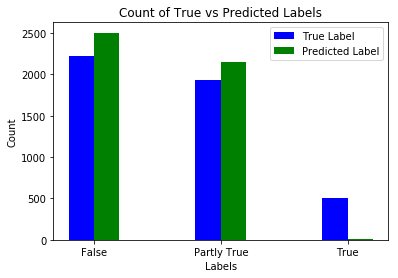

In [143]:
Labels = ['False', 'Partly True', 'True']
x = [1,2,3]

# calculate true list
y_true = [(y_test == 0).sum(), (y_test == 1).sum(), (y_test == 2).sum()]

# calculate prediction list
zero = 0
one = 0
two = 0
for i in range(len(pred)):
    if pred[i] == 0:
        zero += 1
    elif pred[i] == 1:
        one += 1
    elif pred[i] == 2:
        two += 1
y_pred = [zero, one, two]

plt.xticks(x, Labels)
plt.ylabel('Count')
plt.xlabel('Labels')
ax = plt.subplot()
ax.bar([0.9,1.9,2.9], y_true, width=0.2, color='b', align='center')
ax.bar([1.1,2.1,3.1], y_pred, width=0.2, color='g', align='center')
ax.legend(('True Label', 'Predicted Label'), loc='best')
plt.title('Count of True vs Predicted Labels')
plt.show()

### 5.3 Confusion Matrix

The confusion matrix is plotted in this section. The code below sets up the confusion matrix plotting function.

In [223]:
# function to plot confusion matrix

import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

class_names = []

def plot_confusion_matrix(y_true, y_pred, 
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)
plt.show()

As mentioned previously, the confusion matrix below shows us similar trends in the sense that labels 0 and 1 were predicted relatively well when compared to label 2 which is significantly worst (number of true positives is 4 out of the 505 datapoints that are classified as label 2 in test set).

Confusion matrix, without normalization
[[1629  595    4]
 [ 640 1292    2]
 [ 236  265    4]]


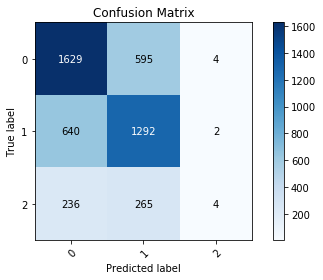

In [224]:
plot_confusion_matrix(y_test, pred,
                      title='Confusion Matrix')